In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Mar 21 09:31:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   31C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_8Layer_XYPretrain_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_10Layer_XYPretrain_X as ModelX
from model.models_mjp_26December20 import ThreeFeature_8Layer_XYPretrain_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_3_P_10L_4S_BN as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 4e-7, 1720)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 30.17 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 29.39 s
Constructing 160000 event dataset took 1.267 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 7.587 s
Constructing 20000 event dataset took 0.1703 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/1814a2acb1ad42deaa08684cf5e2b1e4/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=False)

we also froze 0 weights
Of the 36.5 parameter layers to update in the current model, 36.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4000, out_fea

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


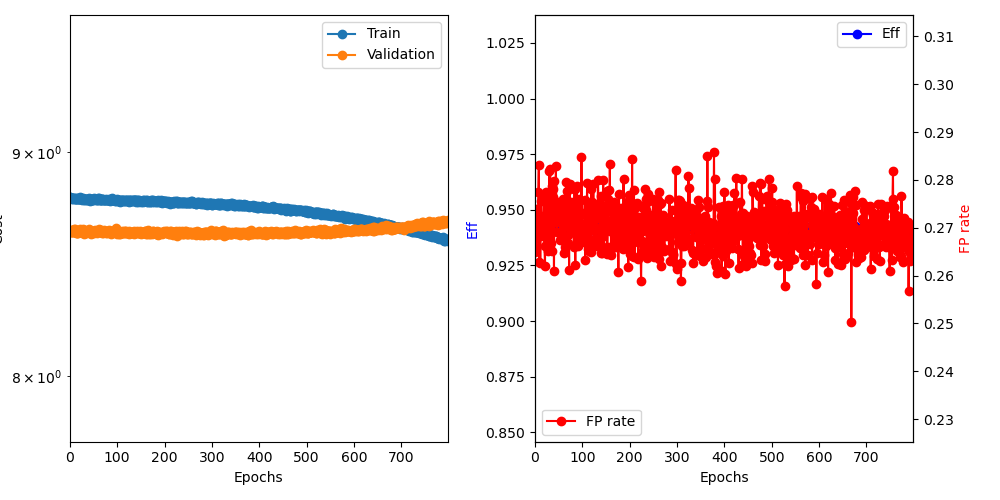

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'ACN_3_P_10L_4S_BN (P6)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1720: train=8.78731, val=8.63554, took 73.172 s
  Validation Found 101550 of 108007, added 5298 (eff 94.02%) (0.265 FP/event)
Result epoch:  1720
Average Eff:  0
Average FP Rate:  0


Epoch 1721: train=8.78697, val=8.62945, took 74.409 s
  Validation Found 101702 of 108007, added 5477 (eff 94.16%) (0.274 FP/event)
Result epoch:  1721
Average Eff:  0
Average FP Rate:  0


Epoch 1722: train=8.7847, val=8.63084, took 72.72 s
  Validation Found 101666 of 108007, added 5409 (eff 94.13%) (0.27 FP/event)
Result epoch:  1722
Average Eff:  0
Average FP Rate:  0


Epoch 1723: train=8.78514, val=8.63921, took 72.622 s
  Validation Found 101589 of 108007, added 5316 (eff 94.06%) (0.266 FP/event)
Result epoch:  1723
Average Eff:  0
Average FP Rate:  0


Epoch 1724: train=8.77904, val=8.62741, took 71.469 s
  Validation Found 101714 of 108007, added 5438 (eff 94.17%) (0.272 FP/event)
Result epoch:  1724
Average Eff:  0
Average FP Rate:  0


Epoch 1725: train=8.78509, val=8.62896, took 72.002 s
  Validation Found 101650 of 108007, added 5358 (eff 94.11%) (0.268 FP/event)
Result epoch:  1725
Average Eff:  0
Average FP Rate:  0


Epoch 1726: train=8.78373, val=8.62835, took 72.233 s
  Validation Found 101666 of 108007, added 5378 (eff 94.13%) (0.269 FP/event)
Result epoch:  1726
Average Eff:  0
Average FP Rate:  0


Epoch 1727: train=8.78081, val=8.63782, took 70.654 s
  Validation Found 101752 of 108007, added 5550 (eff 94.21%) (0.277 FP/event)
Result epoch:  1727
Average Eff:  0
Average FP Rate:  0


Epoch 1728: train=8.7823, val=8.64018, took 71.156 s
  Validation Found 101788 of 108007, added 5661 (eff 94.24%) (0.283 FP/event)
Result epoch:  1728
Average Eff:  0
Average FP Rate:  0


Epoch 1729: train=8.78504, val=8.64127, took 70.102 s
  Validation Found 101552 of 108007, added 5255 (eff 94.02%) (0.263 FP/event)
Result epoch:  1729
Average Eff:  0
Average FP Rate:  0


Epoch 1730: train=8.78181, val=8.63312, took 69.701 s
  Validation Found 101693 of 108007, added 5411 (eff 94.15%) (0.271 FP/event)
Result epoch:  1730
Average Eff:  0
Average FP Rate:  0


Epoch 1731: train=8.78191, val=8.64268, took 69.636 s
  Validation Found 101568 of 108007, added 5254 (eff 94.04%) (0.263 FP/event)
Result epoch:  1731
Average Eff:  0
Average FP Rate:  0


Epoch 1732: train=8.77829, val=8.63064, took 69.739 s
  Validation Found 101688 of 108007, added 5397 (eff 94.15%) (0.27 FP/event)
Result epoch:  1732
Average Eff:  0
Average FP Rate:  0


Epoch 1733: train=8.78229, val=8.63031, took 70.953 s
  Validation Found 101737 of 108007, added 5512 (eff 94.19%) (0.276 FP/event)
Result epoch:  1733
Average Eff:  0
Average FP Rate:  0


Epoch 1734: train=8.78015, val=8.62546, took 70.14 s
  Validation Found 101720 of 108007, added 5443 (eff 94.18%) (0.272 FP/event)
Result epoch:  1734
Average Eff:  0
Average FP Rate:  0


Epoch 1735: train=8.78082, val=8.62687, took 70.094 s
  Validation Found 101688 of 108007, added 5412 (eff 94.15%) (0.271 FP/event)
Result epoch:  1735
Average Eff:  0
Average FP Rate:  0


Epoch 1736: train=8.78265, val=8.62508, took 71.462 s
  Validation Found 101660 of 108007, added 5365 (eff 94.12%) (0.268 FP/event)
Result epoch:  1736
Average Eff:  0
Average FP Rate:  0


Epoch 1737: train=8.78204, val=8.63474, took 71.148 s
  Validation Found 101708 of 108007, added 5444 (eff 94.17%) (0.272 FP/event)
Result epoch:  1737
Average Eff:  0
Average FP Rate:  0


Epoch 1738: train=8.77928, val=8.62541, took 70.148 s
  Validation Found 101689 of 108007, added 5389 (eff 94.15%) (0.269 FP/event)
Result epoch:  1738
Average Eff:  0
Average FP Rate:  0


Epoch 1739: train=8.78127, val=8.63488, took 69.238 s
  Validation Found 101745 of 108007, added 5533 (eff 94.20%) (0.277 FP/event)
Result epoch:  1739
Average Eff:  0
Average FP Rate:  0


Epoch 1740: train=8.78193, val=8.6361, took 70.145 s
  Validation Found 101632 of 108007, added 5322 (eff 94.10%) (0.266 FP/event)
Result epoch:  1740
Average Eff:  0
Average FP Rate:  0


Epoch 1741: train=8.79008, val=8.64066, took 69.896 s
  Validation Found 101565 of 108007, added 5239 (eff 94.04%) (0.262 FP/event)
Result epoch:  1741
Average Eff:  0
Average FP Rate:  0


Epoch 1742: train=8.78133, val=8.63086, took 70.334 s
  Validation Found 101724 of 108007, added 5452 (eff 94.18%) (0.273 FP/event)
Result epoch:  1742
Average Eff:  0
Average FP Rate:  0


Epoch 1743: train=8.78295, val=8.63213, took 72.153 s
  Validation Found 101768 of 108007, added 5542 (eff 94.22%) (0.277 FP/event)
Result epoch:  1743
Average Eff:  0
Average FP Rate:  0


Epoch 1744: train=8.782, val=8.63427, took 70.622 s
  Validation Found 101764 of 108007, added 5548 (eff 94.22%) (0.277 FP/event)
Result epoch:  1744
Average Eff:  0
Average FP Rate:  0


Epoch 1745: train=8.77708, val=8.63044, took 70.44 s
  Validation Found 101761 of 108007, added 5529 (eff 94.22%) (0.276 FP/event)
Result epoch:  1745
Average Eff:  0
Average FP Rate:  0


Epoch 1746: train=8.77801, val=8.63711, took 69.88 s
  Validation Found 101642 of 108007, added 5336 (eff 94.11%) (0.267 FP/event)
Result epoch:  1746
Average Eff:  0
Average FP Rate:  0


Epoch 1747: train=8.78392, val=8.63124, took 71.772 s
  Validation Found 101749 of 108007, added 5526 (eff 94.21%) (0.276 FP/event)
Result epoch:  1747
Average Eff:  0
Average FP Rate:  0


Epoch 1748: train=8.78011, val=8.64114, took 70.656 s
  Validation Found 101599 of 108007, added 5305 (eff 94.07%) (0.265 FP/event)
Result epoch:  1748
Average Eff:  0
Average FP Rate:  0


Epoch 1749: train=8.77772, val=8.61958, took 70.056 s
  Validation Found 101724 of 108007, added 5435 (eff 94.18%) (0.272 FP/event)
Result epoch:  1749
Average Eff:  0
Average FP Rate:  0


Epoch 1750: train=8.77633, val=8.63941, took 72.051 s
  Validation Found 101791 of 108007, added 5637 (eff 94.24%) (0.282 FP/event)
Result epoch:  1750
Average Eff:  0
Average FP Rate:  0


Epoch 1751: train=8.78188, val=8.62692, took 71.987 s
  Validation Found 101722 of 108007, added 5441 (eff 94.18%) (0.272 FP/event)
Result epoch:  1751
Average Eff:  0
Average FP Rate:  0


Epoch 1752: train=8.77528, val=8.62722, took 71.711 s
  Validation Found 101795 of 108007, added 5646 (eff 94.25%) (0.282 FP/event)
Result epoch:  1752
Average Eff:  0
Average FP Rate:  0


Epoch 1753: train=8.77764, val=8.6331, took 71.687 s
  Validation Found 101661 of 108007, added 5335 (eff 94.12%) (0.267 FP/event)
Result epoch:  1753
Average Eff:  0
Average FP Rate:  0


Epoch 1754: train=8.78081, val=8.62384, took 70.448 s
  Validation Found 101705 of 108007, added 5390 (eff 94.17%) (0.269 FP/event)
Result epoch:  1754
Average Eff:  0
Average FP Rate:  0


Epoch 1755: train=8.77771, val=8.63216, took 70.548 s
  Validation Found 101778 of 108007, added 5573 (eff 94.23%) (0.279 FP/event)
Result epoch:  1755
Average Eff:  0
Average FP Rate:  0


Epoch 1756: train=8.77723, val=8.63365, took 71.429 s
  Validation Found 101635 of 108007, added 5302 (eff 94.10%) (0.265 FP/event)
Result epoch:  1756
Average Eff:  0
Average FP Rate:  0


Epoch 1757: train=8.77454, val=8.6326, took 69.738 s
  Validation Found 101739 of 108007, added 5479 (eff 94.20%) (0.274 FP/event)
Result epoch:  1757
Average Eff:  0
Average FP Rate:  0


Epoch 1758: train=8.78155, val=8.63374, took 72.156 s
  Validation Found 101774 of 108007, added 5564 (eff 94.23%) (0.278 FP/event)
Result epoch:  1758
Average Eff:  0
Average FP Rate:  0


Epoch 1759: train=8.7814, val=8.62961, took 69.513 s
  Validation Found 101754 of 108007, added 5527 (eff 94.21%) (0.276 FP/event)
Result epoch:  1759
Average Eff:  0
Average FP Rate:  0


Epoch 1760: train=8.78344, val=8.64061, took 71.555 s
  Validation Found 101561 of 108007, added 5221 (eff 94.03%) (0.261 FP/event)
Result epoch:  1760
Average Eff:  0
Average FP Rate:  0


Epoch 1761: train=8.78006, val=8.63276, took 71.852 s
  Validation Found 101774 of 108007, added 5595 (eff 94.23%) (0.28 FP/event)
Result epoch:  1761
Average Eff:  0
Average FP Rate:  0


Epoch 1762: train=8.7762, val=8.63091, took 71.664 s
  Validation Found 101748 of 108007, added 5511 (eff 94.21%) (0.276 FP/event)
Result epoch:  1762
Average Eff:  0
Average FP Rate:  0


Epoch 1763: train=8.77189, val=8.63073, took 71.787 s
  Validation Found 101704 of 108007, added 5425 (eff 94.16%) (0.271 FP/event)
Result epoch:  1763
Average Eff:  0
Average FP Rate:  0


Epoch 1764: train=8.77872, val=8.6275, took 70.859 s
  Validation Found 101810 of 108007, added 5659 (eff 94.26%) (0.283 FP/event)
Result epoch:  1764
Average Eff:  0
Average FP Rate:  0


Epoch 1765: train=8.78139, val=8.62197, took 71.226 s
  Validation Found 101755 of 108007, added 5493 (eff 94.21%) (0.275 FP/event)
Result epoch:  1765
Average Eff:  0
Average FP Rate:  0


Epoch 1766: train=8.7761, val=8.62381, took 71.423 s
  Validation Found 101708 of 108007, added 5383 (eff 94.17%) (0.269 FP/event)
Result epoch:  1766
Average Eff:  0
Average FP Rate:  0


Epoch 1767: train=8.77636, val=8.63351, took 70.214 s
  Validation Found 101742 of 108007, added 5488 (eff 94.20%) (0.274 FP/event)
Result epoch:  1767
Average Eff:  0
Average FP Rate:  0


Epoch 1768: train=8.77535, val=8.62909, took 69.823 s
  Validation Found 101737 of 108007, added 5456 (eff 94.19%) (0.273 FP/event)
Result epoch:  1768
Average Eff:  0
Average FP Rate:  0


Epoch 1769: train=8.78064, val=8.63408, took 70.348 s
  Validation Found 101745 of 108007, added 5474 (eff 94.20%) (0.274 FP/event)
Result epoch:  1769
Average Eff:  0
Average FP Rate:  0


Epoch 1770: train=8.77791, val=8.62853, took 72.85 s
  Validation Found 101735 of 108007, added 5469 (eff 94.19%) (0.273 FP/event)
Result epoch:  1770
Average Eff:  0
Average FP Rate:  0


Epoch 1771: train=8.78097, val=8.62679, took 71.723 s
  Validation Found 101752 of 108007, added 5472 (eff 94.21%) (0.274 FP/event)
Result epoch:  1771
Average Eff:  0
Average FP Rate:  0


Epoch 1772: train=8.78246, val=8.63153, took 71.935 s
  Validation Found 101715 of 108007, added 5429 (eff 94.17%) (0.271 FP/event)
Result epoch:  1772
Average Eff:  0
Average FP Rate:  0


Epoch 1773: train=8.77623, val=8.6378, took 69.97 s
  Validation Found 101678 of 108007, added 5350 (eff 94.14%) (0.267 FP/event)
Result epoch:  1773
Average Eff:  0
Average FP Rate:  0


Epoch 1774: train=8.77761, val=8.63074, took 71.393 s
  Validation Found 101751 of 108007, added 5499 (eff 94.21%) (0.275 FP/event)
Result epoch:  1774
Average Eff:  0
Average FP Rate:  0


Epoch 1775: train=8.78174, val=8.6316, took 72.155 s
  Validation Found 101734 of 108007, added 5422 (eff 94.19%) (0.271 FP/event)
Result epoch:  1775
Average Eff:  0
Average FP Rate:  0


Epoch 1776: train=8.78191, val=8.62761, took 70.918 s
  Validation Found 101712 of 108007, added 5372 (eff 94.17%) (0.269 FP/event)
Result epoch:  1776
Average Eff:  0
Average FP Rate:  0


Epoch 1777: train=8.77527, val=8.62777, took 72.018 s
  Validation Found 101669 of 108007, added 5357 (eff 94.13%) (0.268 FP/event)
Result epoch:  1777
Average Eff:  0
Average FP Rate:  0


Epoch 1778: train=8.77661, val=8.62672, took 71.22 s
  Validation Found 101744 of 108007, added 5477 (eff 94.20%) (0.274 FP/event)
Result epoch:  1778
Average Eff:  0
Average FP Rate:  0


Epoch 1779: train=8.78479, val=8.63201, took 70.689 s
  Validation Found 101739 of 108007, added 5487 (eff 94.20%) (0.274 FP/event)
Result epoch:  1779
Average Eff:  0
Average FP Rate:  0


Epoch 1780: train=8.77578, val=8.63297, took 70.456 s
  Validation Found 101753 of 108007, added 5520 (eff 94.21%) (0.276 FP/event)
Result epoch:  1780
Average Eff:  0
Average FP Rate:  0


Epoch 1781: train=8.78357, val=8.63359, took 69.782 s
  Validation Found 101713 of 108007, added 5409 (eff 94.17%) (0.27 FP/event)
Result epoch:  1781
Average Eff:  0
Average FP Rate:  0


Epoch 1782: train=8.77842, val=8.64192, took 70.672 s
  Validation Found 101604 of 108007, added 5293 (eff 94.07%) (0.265 FP/event)
Result epoch:  1782
Average Eff:  0
Average FP Rate:  0


Epoch 1783: train=8.77694, val=8.6289, took 70.244 s
  Validation Found 101664 of 108007, added 5320 (eff 94.13%) (0.266 FP/event)
Result epoch:  1783
Average Eff:  0
Average FP Rate:  0


Epoch 1784: train=8.7732, val=8.63338, took 71.966 s
  Validation Found 101750 of 108007, added 5507 (eff 94.21%) (0.275 FP/event)
Result epoch:  1784
Average Eff:  0
Average FP Rate:  0


Epoch 1785: train=8.77588, val=8.63778, took 70.867 s
  Validation Found 101716 of 108007, added 5438 (eff 94.18%) (0.272 FP/event)
Result epoch:  1785
Average Eff:  0
Average FP Rate:  0


Epoch 1786: train=8.7766, val=8.62798, took 71.321 s
  Validation Found 101775 of 108007, added 5593 (eff 94.23%) (0.28 FP/event)
Result epoch:  1786
Average Eff:  0
Average FP Rate:  0


Epoch 1787: train=8.77964, val=8.62568, took 71.425 s
  Validation Found 101726 of 108007, added 5424 (eff 94.18%) (0.271 FP/event)
Result epoch:  1787
Average Eff:  0
Average FP Rate:  0


Epoch 1788: train=8.77594, val=8.63091, took 70.123 s
  Validation Found 101780 of 108007, added 5555 (eff 94.23%) (0.278 FP/event)
Result epoch:  1788
Average Eff:  0
Average FP Rate:  0


Epoch 1789: train=8.78023, val=8.63548, took 71.519 s
  Validation Found 101664 of 108007, added 5336 (eff 94.13%) (0.267 FP/event)
Result epoch:  1789
Average Eff:  0
Average FP Rate:  0


Epoch 1790: train=8.77857, val=8.63374, took 71.946 s
  Validation Found 101687 of 108007, added 5371 (eff 94.15%) (0.269 FP/event)
Result epoch:  1790
Average Eff:  0
Average FP Rate:  0


Epoch 1791: train=8.77443, val=8.6228, took 71.108 s
  Validation Found 101745 of 108007, added 5449 (eff 94.20%) (0.272 FP/event)
Result epoch:  1791
Average Eff:  0
Average FP Rate:  0


Epoch 1792: train=8.7768, val=8.62874, took 71.476 s
  Validation Found 101583 of 108007, added 5224 (eff 94.05%) (0.261 FP/event)
Result epoch:  1792
Average Eff:  0
Average FP Rate:  0


Epoch 1793: train=8.77592, val=8.63651, took 71.685 s
  Validation Found 101786 of 108007, added 5583 (eff 94.24%) (0.279 FP/event)
Result epoch:  1793
Average Eff:  0
Average FP Rate:  0


Epoch 1794: train=8.77491, val=8.63453, took 69.752 s
  Validation Found 101683 of 108007, added 5394 (eff 94.14%) (0.27 FP/event)
Result epoch:  1794
Average Eff:  0
Average FP Rate:  0


Epoch 1795: train=8.77646, val=8.62977, took 70.52 s
  Validation Found 101755 of 108007, added 5487 (eff 94.21%) (0.274 FP/event)
Result epoch:  1795
Average Eff:  0
Average FP Rate:  0


Epoch 1796: train=8.77507, val=8.63018, took 70.009 s
  Validation Found 101744 of 108007, added 5507 (eff 94.20%) (0.275 FP/event)
Result epoch:  1796
Average Eff:  0
Average FP Rate:  0


Epoch 1797: train=8.77768, val=8.62512, took 69.98 s
  Validation Found 101698 of 108007, added 5381 (eff 94.16%) (0.269 FP/event)
Result epoch:  1797
Average Eff:  0
Average FP Rate:  0


Epoch 1798: train=8.77531, val=8.62332, took 72.175 s
  Validation Found 101747 of 108007, added 5469 (eff 94.20%) (0.273 FP/event)
Result epoch:  1798
Average Eff:  0
Average FP Rate:  0


Epoch 1799: train=8.77429, val=8.63236, took 72.223 s
  Validation Found 101710 of 108007, added 5415 (eff 94.17%) (0.271 FP/event)
Result epoch:  1799
Average Eff:  0
Average FP Rate:  0


Epoch 1800: train=8.77419, val=8.63429, took 71.814 s
  Validation Found 101714 of 108007, added 5424 (eff 94.17%) (0.271 FP/event)
Result epoch:  1800
Average Eff:  0
Average FP Rate:  0


Epoch 1801: train=8.77656, val=8.6271, took 71.445 s
  Validation Found 101741 of 108007, added 5465 (eff 94.20%) (0.273 FP/event)
Result epoch:  1801
Average Eff:  0
Average FP Rate:  0


Epoch 1802: train=8.77583, val=8.63613, took 71.57 s
  Validation Found 101623 of 108007, added 5318 (eff 94.09%) (0.266 FP/event)
Result epoch:  1802
Average Eff:  0
Average FP Rate:  0


Epoch 1803: train=8.78038, val=8.62701, took 72.047 s
  Validation Found 101777 of 108007, added 5561 (eff 94.23%) (0.278 FP/event)
Result epoch:  1803
Average Eff:  0
Average FP Rate:  0


Epoch 1804: train=8.77264, val=8.62886, took 70.473 s
  Validation Found 101772 of 108007, added 5564 (eff 94.23%) (0.278 FP/event)
Result epoch:  1804
Average Eff:  0
Average FP Rate:  0


Epoch 1805: train=8.77494, val=8.63282, took 70.617 s
  Validation Found 101587 of 108007, added 5244 (eff 94.06%) (0.262 FP/event)
Result epoch:  1805
Average Eff:  0
Average FP Rate:  0


Epoch 1806: train=8.77778, val=8.62322, took 71.444 s
  Validation Found 101760 of 108007, added 5512 (eff 94.22%) (0.276 FP/event)
Result epoch:  1806
Average Eff:  0
Average FP Rate:  0


Epoch 1807: train=8.78103, val=8.63318, took 70.402 s
  Validation Found 101750 of 108007, added 5499 (eff 94.21%) (0.275 FP/event)
Result epoch:  1807
Average Eff:  0
Average FP Rate:  0


Epoch 1808: train=8.77575, val=8.62098, took 71.685 s
  Validation Found 101790 of 108007, added 5575 (eff 94.24%) (0.279 FP/event)
Result epoch:  1808
Average Eff:  0
Average FP Rate:  0


Epoch 1809: train=8.77526, val=8.6335, took 72.282 s
  Validation Found 101698 of 108007, added 5394 (eff 94.16%) (0.27 FP/event)
Result epoch:  1809
Average Eff:  0
Average FP Rate:  0


Epoch 1810: train=8.78219, val=8.62309, took 70.194 s
  Validation Found 101666 of 108007, added 5324 (eff 94.13%) (0.266 FP/event)
Result epoch:  1810
Average Eff:  0
Average FP Rate:  0


Epoch 1811: train=8.77572, val=8.63042, took 72.421 s
  Validation Found 101738 of 108007, added 5462 (eff 94.20%) (0.273 FP/event)
Result epoch:  1811
Average Eff:  0
Average FP Rate:  0


Epoch 1812: train=8.77519, val=8.62876, took 71.69 s
  Validation Found 101769 of 108007, added 5522 (eff 94.22%) (0.276 FP/event)
Result epoch:  1812
Average Eff:  0
Average FP Rate:  0


Epoch 1813: train=8.77549, val=8.63225, took 72.214 s
  Validation Found 101676 of 108007, added 5359 (eff 94.14%) (0.268 FP/event)
Result epoch:  1813
Average Eff:  0
Average FP Rate:  0


Epoch 1814: train=8.774, val=8.62823, took 71.996 s
  Validation Found 101738 of 108007, added 5455 (eff 94.20%) (0.273 FP/event)
Result epoch:  1814
Average Eff:  0
Average FP Rate:  0


Epoch 1815: train=8.77263, val=8.63648, took 71.197 s
  Validation Found 101667 of 108007, added 5363 (eff 94.13%) (0.268 FP/event)
Result epoch:  1815
Average Eff:  0
Average FP Rate:  0


Epoch 1816: train=8.77368, val=8.6288, took 71.399 s
  Validation Found 101756 of 108007, added 5463 (eff 94.21%) (0.273 FP/event)
Result epoch:  1816
Average Eff:  0
Average FP Rate:  0


Epoch 1817: train=8.77496, val=8.6292, took 71.578 s
  Validation Found 101735 of 108007, added 5417 (eff 94.19%) (0.271 FP/event)
Result epoch:  1817
Average Eff:  0
Average FP Rate:  0


Epoch 1818: train=8.77292, val=8.64513, took 71.762 s
  Validation Found 101835 of 108007, added 5694 (eff 94.29%) (0.285 FP/event)
Result epoch:  1818
Average Eff:  0
Average FP Rate:  0


Epoch 1819: train=8.77341, val=8.62096, took 71.665 s
  Validation Found 101752 of 108007, added 5458 (eff 94.21%) (0.273 FP/event)
Result epoch:  1819
Average Eff:  0
Average FP Rate:  0


Epoch 1820: train=8.77761, val=8.63258, took 72.57 s
  Validation Found 101699 of 108007, added 5413 (eff 94.16%) (0.271 FP/event)
Result epoch:  1820
Average Eff:  0
Average FP Rate:  0


Epoch 1821: train=8.77227, val=8.62876, took 71.954 s
  Validation Found 101655 of 108007, added 5348 (eff 94.12%) (0.267 FP/event)
Result epoch:  1821
Average Eff:  0
Average FP Rate:  0


Epoch 1822: train=8.77338, val=8.62555, took 71.307 s
  Validation Found 101691 of 108007, added 5377 (eff 94.15%) (0.269 FP/event)
Result epoch:  1822
Average Eff:  0
Average FP Rate:  0


Epoch 1823: train=8.77471, val=8.62179, took 70.937 s
  Validation Found 101674 of 108007, added 5341 (eff 94.14%) (0.267 FP/event)
Result epoch:  1823
Average Eff:  0
Average FP Rate:  0


Epoch 1824: train=8.77178, val=8.62989, took 70.176 s
  Validation Found 101677 of 108007, added 5370 (eff 94.14%) (0.268 FP/event)
Result epoch:  1824
Average Eff:  0
Average FP Rate:  0


Epoch 1825: train=8.774, val=8.62289, took 71.818 s
  Validation Found 101767 of 108007, added 5516 (eff 94.22%) (0.276 FP/event)
Result epoch:  1825
Average Eff:  0
Average FP Rate:  0


Epoch 1826: train=8.76691, val=8.62962, took 71.02 s
  Validation Found 101589 of 108007, added 5266 (eff 94.06%) (0.263 FP/event)
Result epoch:  1826
Average Eff:  0
Average FP Rate:  0


Epoch 1827: train=8.76895, val=8.61855, took 71.709 s
  Validation Found 101753 of 108007, added 5468 (eff 94.21%) (0.273 FP/event)
Result epoch:  1827
Average Eff:  0
Average FP Rate:  0


Epoch 1828: train=8.77145, val=8.62935, took 70.918 s
  Validation Found 101719 of 108007, added 5406 (eff 94.18%) (0.27 FP/event)
Result epoch:  1828
Average Eff:  0
Average FP Rate:  0


Epoch 1829: train=8.7749, val=8.62425, took 71.435 s
  Validation Found 101741 of 108007, added 5426 (eff 94.20%) (0.271 FP/event)
Result epoch:  1829
Average Eff:  0
Average FP Rate:  0


Epoch 1830: train=8.7738, val=8.633, took 71.828 s
  Validation Found 101799 of 108007, added 5588 (eff 94.25%) (0.279 FP/event)
Result epoch:  1830
Average Eff:  0
Average FP Rate:  0


Epoch 1831: train=8.77596, val=8.62614, took 70.45 s
  Validation Found 101628 of 108007, added 5310 (eff 94.09%) (0.265 FP/event)
Result epoch:  1831
Average Eff:  0
Average FP Rate:  0


Epoch 1832: train=8.76959, val=8.62583, took 71.969 s
  Validation Found 101720 of 108007, added 5401 (eff 94.18%) (0.27 FP/event)
Result epoch:  1832
Average Eff:  0
Average FP Rate:  0


Epoch 1833: train=8.77303, val=8.62707, took 71.381 s
  Validation Found 101709 of 108007, added 5400 (eff 94.17%) (0.27 FP/event)
Result epoch:  1833
Average Eff:  0
Average FP Rate:  0


Epoch 1834: train=8.77245, val=8.6239, took 71.703 s
  Validation Found 101639 of 108007, added 5302 (eff 94.10%) (0.265 FP/event)
Result epoch:  1834
Average Eff:  0
Average FP Rate:  0


Epoch 1835: train=8.77312, val=8.63528, took 72.28 s
  Validation Found 101773 of 108007, added 5504 (eff 94.23%) (0.275 FP/event)
Result epoch:  1835
Average Eff:  0
Average FP Rate:  0


Epoch 1836: train=8.77387, val=8.62593, took 70.847 s
  Validation Found 101678 of 108007, added 5349 (eff 94.14%) (0.267 FP/event)
Result epoch:  1836
Average Eff:  0
Average FP Rate:  0


Epoch 1837: train=8.77013, val=8.63358, took 70.764 s
  Validation Found 101660 of 108007, added 5355 (eff 94.12%) (0.268 FP/event)
Result epoch:  1837
Average Eff:  0
Average FP Rate:  0


Epoch 1838: train=8.77254, val=8.62392, took 71.516 s
  Validation Found 101640 of 108007, added 5300 (eff 94.11%) (0.265 FP/event)
Result epoch:  1838
Average Eff:  0
Average FP Rate:  0


Epoch 1839: train=8.7735, val=8.63166, took 72.471 s
  Validation Found 101791 of 108007, added 5562 (eff 94.24%) (0.278 FP/event)
Result epoch:  1839
Average Eff:  0
Average FP Rate:  0


Epoch 1840: train=8.77606, val=8.62665, took 72.888 s
  Validation Found 101752 of 108007, added 5453 (eff 94.21%) (0.273 FP/event)
Result epoch:  1840
Average Eff:  0
Average FP Rate:  0


Epoch 1841: train=8.77327, val=8.62765, took 70.835 s
  Validation Found 101774 of 108007, added 5506 (eff 94.23%) (0.275 FP/event)
Result epoch:  1841
Average Eff:  0
Average FP Rate:  0


Epoch 1842: train=8.77051, val=8.62509, took 71.163 s
  Validation Found 101721 of 108007, added 5389 (eff 94.18%) (0.269 FP/event)
Result epoch:  1842
Average Eff:  0
Average FP Rate:  0


Epoch 1843: train=8.77169, val=8.62908, took 70.866 s
  Validation Found 101803 of 108007, added 5582 (eff 94.26%) (0.279 FP/event)
Result epoch:  1843
Average Eff:  0
Average FP Rate:  0


Epoch 1844: train=8.76821, val=8.62477, took 69.079 s
  Validation Found 101763 of 108007, added 5461 (eff 94.22%) (0.273 FP/event)
Result epoch:  1844
Average Eff:  0
Average FP Rate:  0


Epoch 1845: train=8.77741, val=8.61964, took 72.139 s
  Validation Found 101679 of 108007, added 5328 (eff 94.14%) (0.266 FP/event)
Result epoch:  1845
Average Eff:  0
Average FP Rate:  0


Epoch 1846: train=8.7735, val=8.63364, took 71.388 s
  Validation Found 101701 of 108007, added 5402 (eff 94.16%) (0.27 FP/event)
Result epoch:  1846
Average Eff:  0
Average FP Rate:  0


Epoch 1847: train=8.77255, val=8.62506, took 72.137 s
  Validation Found 101757 of 108007, added 5476 (eff 94.21%) (0.274 FP/event)
Result epoch:  1847
Average Eff:  0
Average FP Rate:  0


Epoch 1848: train=8.77598, val=8.62351, took 71.632 s
  Validation Found 101749 of 108007, added 5445 (eff 94.21%) (0.272 FP/event)
Result epoch:  1848
Average Eff:  0
Average FP Rate:  0


Epoch 1849: train=8.77155, val=8.62502, took 70.364 s
  Validation Found 101685 of 108007, added 5355 (eff 94.15%) (0.268 FP/event)
Result epoch:  1849
Average Eff:  0
Average FP Rate:  0


Epoch 1850: train=8.77643, val=8.62349, took 70.373 s
  Validation Found 101663 of 108007, added 5323 (eff 94.13%) (0.266 FP/event)
Result epoch:  1850
Average Eff:  0
Average FP Rate:  0


Epoch 1851: train=8.76987, val=8.63117, took 70.775 s
  Validation Found 101768 of 108007, added 5491 (eff 94.22%) (0.275 FP/event)
Result epoch:  1851
Average Eff:  0
Average FP Rate:  0


Epoch 1852: train=8.77435, val=8.63006, took 71.892 s
  Validation Found 101729 of 108007, added 5442 (eff 94.19%) (0.272 FP/event)
Result epoch:  1852
Average Eff:  0
Average FP Rate:  0


Epoch 1853: train=8.77711, val=8.62475, took 72.316 s
  Validation Found 101796 of 108007, added 5598 (eff 94.25%) (0.28 FP/event)
Result epoch:  1853
Average Eff:  0
Average FP Rate:  0


Epoch 1854: train=8.77262, val=8.63013, took 71.151 s
  Validation Found 101757 of 108007, added 5499 (eff 94.21%) (0.275 FP/event)
Result epoch:  1854
Average Eff:  0
Average FP Rate:  0


Epoch 1855: train=8.77397, val=8.63334, took 71.955 s
  Validation Found 101755 of 108007, added 5471 (eff 94.21%) (0.274 FP/event)
Result epoch:  1855
Average Eff:  0
Average FP Rate:  0


Epoch 1856: train=8.77552, val=8.61957, took 71.335 s
  Validation Found 101724 of 108007, added 5392 (eff 94.18%) (0.27 FP/event)
Result epoch:  1856
Average Eff:  0
Average FP Rate:  0


Epoch 1857: train=8.77359, val=8.63123, took 71.177 s
  Validation Found 101656 of 108007, added 5335 (eff 94.12%) (0.267 FP/event)
Result epoch:  1857
Average Eff:  0
Average FP Rate:  0


Epoch 1858: train=8.77443, val=8.62623, took 72.106 s
  Validation Found 101673 of 108007, added 5357 (eff 94.14%) (0.268 FP/event)
Result epoch:  1858
Average Eff:  0
Average FP Rate:  0


Epoch 1859: train=8.77754, val=8.6299, took 70.91 s
  Validation Found 101794 of 108007, added 5532 (eff 94.25%) (0.277 FP/event)
Result epoch:  1859
Average Eff:  0
Average FP Rate:  0


Epoch 1860: train=8.76699, val=8.62625, took 71.895 s
  Validation Found 101636 of 108007, added 5296 (eff 94.10%) (0.265 FP/event)
Result epoch:  1860
Average Eff:  0
Average FP Rate:  0


Epoch 1861: train=8.77247, val=8.63029, took 70.893 s
  Validation Found 101670 of 108007, added 5360 (eff 94.13%) (0.268 FP/event)
Result epoch:  1861
Average Eff:  0
Average FP Rate:  0


Epoch 1862: train=8.77629, val=8.63209, took 70.679 s
  Validation Found 101619 of 108007, added 5296 (eff 94.09%) (0.265 FP/event)
Result epoch:  1862
Average Eff:  0
Average FP Rate:  0


Epoch 1863: train=8.76887, val=8.62915, took 69.78 s
  Validation Found 101770 of 108007, added 5492 (eff 94.23%) (0.275 FP/event)
Result epoch:  1863
Average Eff:  0
Average FP Rate:  0


Epoch 1864: train=8.77436, val=8.6271, took 70.077 s
  Validation Found 101793 of 108007, added 5599 (eff 94.25%) (0.28 FP/event)
Result epoch:  1864
Average Eff:  0
Average FP Rate:  0


Epoch 1865: train=8.76832, val=8.6226, took 70.296 s
  Validation Found 101698 of 108007, added 5392 (eff 94.16%) (0.27 FP/event)
Result epoch:  1865
Average Eff:  0
Average FP Rate:  0


Epoch 1866: train=8.77345, val=8.62624, took 71.063 s
  Validation Found 101729 of 108007, added 5430 (eff 94.19%) (0.271 FP/event)
Result epoch:  1866
Average Eff:  0
Average FP Rate:  0


Epoch 1867: train=8.77112, val=8.62422, took 71.899 s
  Validation Found 101764 of 108007, added 5472 (eff 94.22%) (0.274 FP/event)
Result epoch:  1867
Average Eff:  0
Average FP Rate:  0


Epoch 1868: train=8.7714, val=8.63244, took 71.553 s
  Validation Found 101755 of 108007, added 5489 (eff 94.21%) (0.274 FP/event)
Result epoch:  1868
Average Eff:  0
Average FP Rate:  0


Epoch 1869: train=8.76943, val=8.62635, took 71.005 s
  Validation Found 101734 of 108007, added 5428 (eff 94.19%) (0.271 FP/event)
Result epoch:  1869
Average Eff:  0
Average FP Rate:  0


Epoch 1870: train=8.77098, val=8.61899, took 71.202 s
  Validation Found 101737 of 108007, added 5434 (eff 94.19%) (0.272 FP/event)
Result epoch:  1870
Average Eff:  0
Average FP Rate:  0


Epoch 1871: train=8.76525, val=8.62549, took 71.37 s
  Validation Found 101790 of 108007, added 5553 (eff 94.24%) (0.278 FP/event)
Result epoch:  1871
Average Eff:  0
Average FP Rate:  0


Epoch 1872: train=8.77202, val=8.62818, took 71.195 s
  Validation Found 101622 of 108007, added 5292 (eff 94.09%) (0.265 FP/event)
Result epoch:  1872
Average Eff:  0
Average FP Rate:  0


Epoch 1873: train=8.77061, val=8.62444, took 71.978 s
  Validation Found 101650 of 108007, added 5318 (eff 94.11%) (0.266 FP/event)
Result epoch:  1873
Average Eff:  0
Average FP Rate:  0


Epoch 1874: train=8.7734, val=8.62596, took 71.36 s
  Validation Found 101712 of 108007, added 5415 (eff 94.17%) (0.271 FP/event)
Result epoch:  1874
Average Eff:  0
Average FP Rate:  0


Epoch 1875: train=8.76732, val=8.62303, took 70.669 s
  Validation Found 101786 of 108007, added 5522 (eff 94.24%) (0.276 FP/event)
Result epoch:  1875
Average Eff:  0
Average FP Rate:  0


Epoch 1876: train=8.77258, val=8.63124, took 72.196 s
  Validation Found 101802 of 108007, added 5557 (eff 94.26%) (0.278 FP/event)
Result epoch:  1876
Average Eff:  0
Average FP Rate:  0


Epoch 1877: train=8.77335, val=8.62723, took 71.805 s
  Validation Found 101766 of 108007, added 5471 (eff 94.22%) (0.274 FP/event)
Result epoch:  1877
Average Eff:  0
Average FP Rate:  0


Epoch 1878: train=8.76876, val=8.63411, took 71.92 s
  Validation Found 101837 of 108007, added 5667 (eff 94.29%) (0.283 FP/event)
Result epoch:  1878
Average Eff:  0
Average FP Rate:  0


Epoch 1879: train=8.76992, val=8.6333, took 70.854 s
  Validation Found 101698 of 108007, added 5388 (eff 94.16%) (0.269 FP/event)
Result epoch:  1879
Average Eff:  0
Average FP Rate:  0


Epoch 1880: train=8.77378, val=8.62152, took 70.089 s
  Validation Found 101715 of 108007, added 5387 (eff 94.17%) (0.269 FP/event)
Result epoch:  1880
Average Eff:  0
Average FP Rate:  0


Epoch 1881: train=8.76899, val=8.6228, took 71.343 s
  Validation Found 101633 of 108007, added 5288 (eff 94.10%) (0.264 FP/event)
Result epoch:  1881
Average Eff:  0
Average FP Rate:  0


Epoch 1882: train=8.77325, val=8.62089, took 71.042 s
  Validation Found 101667 of 108007, added 5317 (eff 94.13%) (0.266 FP/event)
Result epoch:  1882
Average Eff:  0
Average FP Rate:  0


Epoch 1883: train=8.76791, val=8.6271, took 71.905 s
  Validation Found 101724 of 108007, added 5419 (eff 94.18%) (0.271 FP/event)
Result epoch:  1883
Average Eff:  0
Average FP Rate:  0


Epoch 1884: train=8.77, val=8.63321, took 70.05 s
  Validation Found 101772 of 108007, added 5493 (eff 94.23%) (0.275 FP/event)
Result epoch:  1884
Average Eff:  0
Average FP Rate:  0


Epoch 1885: train=8.77139, val=8.62703, took 70.69 s
  Validation Found 101665 of 108007, added 5328 (eff 94.13%) (0.266 FP/event)
Result epoch:  1885
Average Eff:  0
Average FP Rate:  0


Epoch 1886: train=8.76408, val=8.63626, took 71.034 s
  Validation Found 101698 of 108007, added 5402 (eff 94.16%) (0.27 FP/event)
Result epoch:  1886
Average Eff:  0
Average FP Rate:  0


Epoch 1887: train=8.76894, val=8.62531, took 70.47 s
  Validation Found 101787 of 108007, added 5506 (eff 94.24%) (0.275 FP/event)
Result epoch:  1887
Average Eff:  0
Average FP Rate:  0


Epoch 1888: train=8.77226, val=8.62241, took 71.573 s
  Validation Found 101763 of 108007, added 5455 (eff 94.22%) (0.273 FP/event)
Result epoch:  1888
Average Eff:  0
Average FP Rate:  0


Epoch 1889: train=8.76723, val=8.61883, took 70.822 s
  Validation Found 101739 of 108007, added 5407 (eff 94.20%) (0.27 FP/event)
Result epoch:  1889
Average Eff:  0
Average FP Rate:  0


Epoch 1890: train=8.76814, val=8.62608, took 71.213 s
  Validation Found 101667 of 108007, added 5321 (eff 94.13%) (0.266 FP/event)
Result epoch:  1890
Average Eff:  0
Average FP Rate:  0


Epoch 1891: train=8.76932, val=8.62315, took 71.541 s
  Validation Found 101727 of 108007, added 5395 (eff 94.19%) (0.27 FP/event)
Result epoch:  1891
Average Eff:  0
Average FP Rate:  0


Epoch 1892: train=8.77409, val=8.63003, took 71.413 s
  Validation Found 101723 of 108007, added 5412 (eff 94.18%) (0.271 FP/event)
Result epoch:  1892
Average Eff:  0
Average FP Rate:  0


Epoch 1893: train=8.76658, val=8.62244, took 71.924 s
  Validation Found 101711 of 108007, added 5388 (eff 94.17%) (0.269 FP/event)
Result epoch:  1893
Average Eff:  0
Average FP Rate:  0


Epoch 1894: train=8.77299, val=8.63138, took 72.252 s
  Validation Found 101681 of 108007, added 5352 (eff 94.14%) (0.268 FP/event)
Result epoch:  1894
Average Eff:  0
Average FP Rate:  0


Epoch 1895: train=8.77305, val=8.63187, took 71.5 s
  Validation Found 101731 of 108007, added 5443 (eff 94.19%) (0.272 FP/event)
Result epoch:  1895
Average Eff:  0
Average FP Rate:  0


Epoch 1896: train=8.77019, val=8.6331, took 71.481 s
  Validation Found 101572 of 108007, added 5214 (eff 94.04%) (0.261 FP/event)
Result epoch:  1896
Average Eff:  0
Average FP Rate:  0


Epoch 1897: train=8.76585, val=8.62907, took 70.836 s
  Validation Found 101800 of 108007, added 5543 (eff 94.25%) (0.277 FP/event)
Result epoch:  1897
Average Eff:  0
Average FP Rate:  0


Epoch 1898: train=8.77002, val=8.62435, took 71.44 s
  Validation Found 101778 of 108007, added 5476 (eff 94.23%) (0.274 FP/event)
Result epoch:  1898
Average Eff:  0
Average FP Rate:  0


Epoch 1899: train=8.76968, val=8.63137, took 71.833 s
  Validation Found 101741 of 108007, added 5442 (eff 94.20%) (0.272 FP/event)
Result epoch:  1899
Average Eff:  0
Average FP Rate:  0


Epoch 1900: train=8.77284, val=8.62276, took 69.685 s
  Validation Found 101711 of 108007, added 5380 (eff 94.17%) (0.269 FP/event)
Result epoch:  1900
Average Eff:  0
Average FP Rate:  0


Epoch 1901: train=8.76983, val=8.62575, took 71.268 s
  Validation Found 101767 of 108007, added 5481 (eff 94.22%) (0.274 FP/event)
Result epoch:  1901
Average Eff:  0
Average FP Rate:  0


Epoch 1902: train=8.76541, val=8.62871, took 70.746 s
  Validation Found 101668 of 108007, added 5340 (eff 94.13%) (0.267 FP/event)
Result epoch:  1902
Average Eff:  0
Average FP Rate:  0


Epoch 1903: train=8.77293, val=8.62197, took 70.338 s
  Validation Found 101724 of 108007, added 5392 (eff 94.18%) (0.27 FP/event)
Result epoch:  1903
Average Eff:  0
Average FP Rate:  0


Epoch 1904: train=8.76674, val=8.63182, took 71.943 s
  Validation Found 101742 of 108007, added 5433 (eff 94.20%) (0.272 FP/event)
Result epoch:  1904
Average Eff:  0
Average FP Rate:  0


Epoch 1905: train=8.76854, val=8.61987, took 71.473 s
  Validation Found 101671 of 108007, added 5313 (eff 94.13%) (0.266 FP/event)
Result epoch:  1905
Average Eff:  0
Average FP Rate:  0


Epoch 1906: train=8.77291, val=8.61778, took 71.445 s
  Validation Found 101782 of 108007, added 5467 (eff 94.24%) (0.273 FP/event)
Result epoch:  1906
Average Eff:  0
Average FP Rate:  0


Epoch 1907: train=8.77468, val=8.63072, took 71.843 s
  Validation Found 101823 of 108007, added 5602 (eff 94.27%) (0.28 FP/event)
Result epoch:  1907
Average Eff:  0
Average FP Rate:  0


Epoch 1908: train=8.76721, val=8.61815, took 72.076 s
  Validation Found 101692 of 108007, added 5337 (eff 94.15%) (0.267 FP/event)
Result epoch:  1908
Average Eff:  0
Average FP Rate:  0


Epoch 1909: train=8.76918, val=8.63009, took 72.21 s
  Validation Found 101701 of 108007, added 5373 (eff 94.16%) (0.269 FP/event)
Result epoch:  1909
Average Eff:  0
Average FP Rate:  0


Epoch 1910: train=8.76958, val=8.62671, took 70.98 s
  Validation Found 101779 of 108007, added 5476 (eff 94.23%) (0.274 FP/event)
Result epoch:  1910
Average Eff:  0
Average FP Rate:  0


Epoch 1911: train=8.76414, val=8.62464, took 69.938 s
  Validation Found 101706 of 108007, added 5407 (eff 94.17%) (0.27 FP/event)
Result epoch:  1911
Average Eff:  0
Average FP Rate:  0


Epoch 1912: train=8.77321, val=8.62628, took 69.714 s
  Validation Found 101681 of 108007, added 5325 (eff 94.14%) (0.266 FP/event)
Result epoch:  1912
Average Eff:  0
Average FP Rate:  0


Epoch 1913: train=8.76755, val=8.62826, took 71.238 s
  Validation Found 101659 of 108007, added 5314 (eff 94.12%) (0.266 FP/event)
Result epoch:  1913
Average Eff:  0
Average FP Rate:  0


Epoch 1914: train=8.76137, val=8.62048, took 70.203 s
  Validation Found 101721 of 108007, added 5376 (eff 94.18%) (0.269 FP/event)
Result epoch:  1914
Average Eff:  0
Average FP Rate:  0


Epoch 1915: train=8.77182, val=8.62591, took 69.895 s
  Validation Found 101792 of 108007, added 5508 (eff 94.25%) (0.275 FP/event)
Result epoch:  1915
Average Eff:  0
Average FP Rate:  0


Epoch 1916: train=8.77149, val=8.62905, took 71.336 s
  Validation Found 101661 of 108007, added 5333 (eff 94.12%) (0.267 FP/event)
Result epoch:  1916
Average Eff:  0
Average FP Rate:  0


Epoch 1917: train=8.76837, val=8.62661, took 71.332 s
  Validation Found 101613 of 108007, added 5234 (eff 94.08%) (0.262 FP/event)
Result epoch:  1917
Average Eff:  0
Average FP Rate:  0


Epoch 1918: train=8.76684, val=8.62891, took 70.446 s
  Validation Found 101795 of 108007, added 5495 (eff 94.25%) (0.275 FP/event)
Result epoch:  1918
Average Eff:  0
Average FP Rate:  0


Epoch 1919: train=8.76932, val=8.63396, took 71.636 s
  Validation Found 101799 of 108007, added 5539 (eff 94.25%) (0.277 FP/event)
Result epoch:  1919
Average Eff:  0
Average FP Rate:  0


Epoch 1920: train=8.76875, val=8.62917, took 70.504 s
  Validation Found 101788 of 108007, added 5488 (eff 94.24%) (0.274 FP/event)
Result epoch:  1920
Average Eff:  0
Average FP Rate:  0


Epoch 1921: train=8.77154, val=8.62713, took 71.244 s
  Validation Found 101645 of 108007, added 5292 (eff 94.11%) (0.265 FP/event)
Result epoch:  1921
Average Eff:  0
Average FP Rate:  0


Epoch 1922: train=8.76623, val=8.62861, took 69.761 s
  Validation Found 101670 of 108007, added 5329 (eff 94.13%) (0.266 FP/event)
Result epoch:  1922
Average Eff:  0
Average FP Rate:  0


Epoch 1923: train=8.76665, val=8.62625, took 71.263 s
  Validation Found 101752 of 108007, added 5403 (eff 94.21%) (0.27 FP/event)
Result epoch:  1923
Average Eff:  0
Average FP Rate:  0


Epoch 1924: train=8.77084, val=8.63155, took 72.16 s
  Validation Found 101631 of 108007, added 5284 (eff 94.10%) (0.264 FP/event)
Result epoch:  1924
Average Eff:  0
Average FP Rate:  0


Epoch 1925: train=8.76355, val=8.63423, took 71.544 s
  Validation Found 101858 of 108007, added 5688 (eff 94.31%) (0.284 FP/event)
Result epoch:  1925
Average Eff:  0
Average FP Rate:  0


Epoch 1926: train=8.76487, val=8.62579, took 71.151 s
  Validation Found 101700 of 108007, added 5379 (eff 94.16%) (0.269 FP/event)
Result epoch:  1926
Average Eff:  0
Average FP Rate:  0


Epoch 1927: train=8.76589, val=8.62724, took 71.576 s
  Validation Found 101763 of 108007, added 5492 (eff 94.22%) (0.275 FP/event)
Result epoch:  1927
Average Eff:  0
Average FP Rate:  0


Epoch 1928: train=8.77081, val=8.62576, took 71.231 s
  Validation Found 101783 of 108007, added 5483 (eff 94.24%) (0.274 FP/event)
Result epoch:  1928
Average Eff:  0
Average FP Rate:  0


Epoch 1929: train=8.76644, val=8.62057, took 71.531 s
  Validation Found 101807 of 108007, added 5559 (eff 94.26%) (0.278 FP/event)
Result epoch:  1929
Average Eff:  0
Average FP Rate:  0


Epoch 1930: train=8.76489, val=8.62023, took 72.247 s
  Validation Found 101647 of 108007, added 5277 (eff 94.11%) (0.264 FP/event)
Result epoch:  1930
Average Eff:  0
Average FP Rate:  0


Epoch 1931: train=8.75898, val=8.63297, took 69.729 s
  Validation Found 101737 of 108007, added 5435 (eff 94.19%) (0.272 FP/event)
Result epoch:  1931
Average Eff:  0
Average FP Rate:  0


Epoch 1932: train=8.76812, val=8.62484, took 71.479 s
  Validation Found 101720 of 108007, added 5401 (eff 94.18%) (0.27 FP/event)
Result epoch:  1932
Average Eff:  0
Average FP Rate:  0


Epoch 1933: train=8.76721, val=8.63416, took 71.405 s
  Validation Found 101664 of 108007, added 5344 (eff 94.13%) (0.267 FP/event)
Result epoch:  1933
Average Eff:  0
Average FP Rate:  0


Epoch 1934: train=8.76801, val=8.62144, took 71.425 s
  Validation Found 101779 of 108007, added 5485 (eff 94.23%) (0.274 FP/event)
Result epoch:  1934
Average Eff:  0
Average FP Rate:  0


Epoch 1935: train=8.76725, val=8.62332, took 71.656 s
  Validation Found 101710 of 108007, added 5395 (eff 94.17%) (0.27 FP/event)
Result epoch:  1935
Average Eff:  0
Average FP Rate:  0


Epoch 1936: train=8.76506, val=8.62724, took 70.962 s
  Validation Found 101794 of 108007, added 5505 (eff 94.25%) (0.275 FP/event)
Result epoch:  1936
Average Eff:  0
Average FP Rate:  0


Epoch 1937: train=8.76199, val=8.61737, took 72.319 s
  Validation Found 101687 of 108007, added 5340 (eff 94.15%) (0.267 FP/event)
Result epoch:  1937
Average Eff:  0
Average FP Rate:  0


Epoch 1938: train=8.76314, val=8.62856, took 71.983 s
  Validation Found 101631 of 108007, added 5270 (eff 94.10%) (0.263 FP/event)
Result epoch:  1938
Average Eff:  0
Average FP Rate:  0


Epoch 1939: train=8.76927, val=8.62667, took 70.95 s
  Validation Found 101763 of 108007, added 5443 (eff 94.22%) (0.272 FP/event)
Result epoch:  1939
Average Eff:  0
Average FP Rate:  0


Epoch 1940: train=8.76365, val=8.62958, took 71.014 s
  Validation Found 101755 of 108007, added 5444 (eff 94.21%) (0.272 FP/event)
Result epoch:  1940
Average Eff:  0
Average FP Rate:  0


Epoch 1941: train=8.76417, val=8.62328, took 71.779 s
  Validation Found 101720 of 108007, added 5389 (eff 94.18%) (0.269 FP/event)
Result epoch:  1941
Average Eff:  0
Average FP Rate:  0


Epoch 1942: train=8.76561, val=8.6259, took 71.273 s
  Validation Found 101746 of 108007, added 5418 (eff 94.20%) (0.271 FP/event)
Result epoch:  1942
Average Eff:  0
Average FP Rate:  0


Epoch 1943: train=8.76496, val=8.62945, took 72.289 s
  Validation Found 101659 of 108007, added 5294 (eff 94.12%) (0.265 FP/event)
Result epoch:  1943
Average Eff:  0
Average FP Rate:  0


Epoch 1944: train=8.76417, val=8.63542, took 71.179 s
  Validation Found 101580 of 108007, added 5179 (eff 94.05%) (0.259 FP/event)
Result epoch:  1944
Average Eff:  0
Average FP Rate:  0


Epoch 1945: train=8.77005, val=8.6315, took 71.648 s
  Validation Found 101687 of 108007, added 5344 (eff 94.15%) (0.267 FP/event)
Result epoch:  1945
Average Eff:  0
Average FP Rate:  0


Epoch 1946: train=8.7705, val=8.61318, took 71.741 s
  Validation Found 101801 of 108007, added 5491 (eff 94.25%) (0.275 FP/event)
Result epoch:  1946
Average Eff:  0
Average FP Rate:  0


Epoch 1947: train=8.76346, val=8.62715, took 70.669 s
  Validation Found 101641 of 108007, added 5293 (eff 94.11%) (0.265 FP/event)
Result epoch:  1947
Average Eff:  0
Average FP Rate:  0


Epoch 1948: train=8.762, val=8.63132, took 70.508 s
  Validation Found 101713 of 108007, added 5386 (eff 94.17%) (0.269 FP/event)
Result epoch:  1948
Average Eff:  0
Average FP Rate:  0


Epoch 1949: train=8.76066, val=8.62368, took 71.272 s
  Validation Found 101792 of 108007, added 5482 (eff 94.25%) (0.274 FP/event)
Result epoch:  1949
Average Eff:  0
Average FP Rate:  0


Epoch 1950: train=8.76684, val=8.63238, took 70.521 s
  Validation Found 101731 of 108007, added 5405 (eff 94.19%) (0.27 FP/event)
Result epoch:  1950
Average Eff:  0
Average FP Rate:  0


Epoch 1951: train=8.76741, val=8.62584, took 72.388 s
  Validation Found 101764 of 108007, added 5429 (eff 94.22%) (0.271 FP/event)
Result epoch:  1951
Average Eff:  0
Average FP Rate:  0


Epoch 1952: train=8.76227, val=8.62006, took 70.121 s
  Validation Found 101821 of 108007, added 5563 (eff 94.27%) (0.278 FP/event)
Result epoch:  1952
Average Eff:  0
Average FP Rate:  0


Epoch 1953: train=8.76493, val=8.62924, took 70.287 s
  Validation Found 101733 of 108007, added 5418 (eff 94.19%) (0.271 FP/event)
Result epoch:  1953
Average Eff:  0
Average FP Rate:  0


Epoch 1954: train=8.76202, val=8.62769, took 71.887 s
  Validation Found 101803 of 108007, added 5520 (eff 94.26%) (0.276 FP/event)
Result epoch:  1954
Average Eff:  0
Average FP Rate:  0


Epoch 1955: train=8.76667, val=8.62871, took 71.635 s
  Validation Found 101780 of 108007, added 5476 (eff 94.23%) (0.274 FP/event)
Result epoch:  1955
Average Eff:  0
Average FP Rate:  0


Epoch 1956: train=8.76564, val=8.62129, took 70.599 s
  Validation Found 101710 of 108007, added 5330 (eff 94.17%) (0.266 FP/event)
Result epoch:  1956
Average Eff:  0
Average FP Rate:  0


Epoch 1957: train=8.768, val=8.63233, took 71.425 s
  Validation Found 101637 of 108007, added 5273 (eff 94.10%) (0.264 FP/event)
Result epoch:  1957
Average Eff:  0
Average FP Rate:  0


Epoch 1958: train=8.76263, val=8.61969, took 71.197 s
  Validation Found 101704 of 108007, added 5333 (eff 94.16%) (0.267 FP/event)
Result epoch:  1958
Average Eff:  0
Average FP Rate:  0


Epoch 1959: train=8.76575, val=8.62351, took 70.557 s
  Validation Found 101815 of 108007, added 5540 (eff 94.27%) (0.277 FP/event)
Result epoch:  1959
Average Eff:  0
Average FP Rate:  0


Epoch 1960: train=8.75976, val=8.62633, took 71.027 s
  Validation Found 101680 of 108007, added 5307 (eff 94.14%) (0.265 FP/event)
Result epoch:  1960
Average Eff:  0
Average FP Rate:  0


Epoch 1961: train=8.76408, val=8.62752, took 71.021 s
  Validation Found 101794 of 108007, added 5510 (eff 94.25%) (0.275 FP/event)
Result epoch:  1961
Average Eff:  0
Average FP Rate:  0


Epoch 1962: train=8.76427, val=8.62211, took 71.156 s
  Validation Found 101719 of 108007, added 5364 (eff 94.18%) (0.268 FP/event)
Result epoch:  1962
Average Eff:  0
Average FP Rate:  0


Epoch 1963: train=8.76323, val=8.6345, took 71.348 s
  Validation Found 101653 of 108007, added 5297 (eff 94.12%) (0.265 FP/event)
Result epoch:  1963
Average Eff:  0
Average FP Rate:  0


Epoch 1964: train=8.76678, val=8.6235, took 70.32 s
  Validation Found 101790 of 108007, added 5453 (eff 94.24%) (0.273 FP/event)
Result epoch:  1964
Average Eff:  0
Average FP Rate:  0


Epoch 1965: train=8.75943, val=8.62359, took 70.482 s
  Validation Found 101763 of 108007, added 5431 (eff 94.22%) (0.272 FP/event)
Result epoch:  1965
Average Eff:  0
Average FP Rate:  0


Epoch 1966: train=8.76208, val=8.63491, took 71.619 s
  Validation Found 101722 of 108007, added 5425 (eff 94.18%) (0.271 FP/event)
Result epoch:  1966
Average Eff:  0
Average FP Rate:  0


Epoch 1967: train=8.76149, val=8.62054, took 71.946 s
  Validation Found 101765 of 108007, added 5437 (eff 94.22%) (0.272 FP/event)
Result epoch:  1967
Average Eff:  0
Average FP Rate:  0


Epoch 1968: train=8.76443, val=8.62198, took 71.048 s
  Validation Found 101703 of 108007, added 5338 (eff 94.16%) (0.267 FP/event)
Result epoch:  1968
Average Eff:  0
Average FP Rate:  0


Epoch 1969: train=8.76432, val=8.62417, took 70.115 s
  Validation Found 101797 of 108007, added 5519 (eff 94.25%) (0.276 FP/event)
Result epoch:  1969
Average Eff:  0
Average FP Rate:  0


Epoch 1970: train=8.75976, val=8.61984, took 71.526 s
  Validation Found 101725 of 108007, added 5377 (eff 94.18%) (0.269 FP/event)
Result epoch:  1970
Average Eff:  0
Average FP Rate:  0


Epoch 1971: train=8.76328, val=8.62848, took 71.422 s
  Validation Found 101728 of 108007, added 5385 (eff 94.19%) (0.269 FP/event)
Result epoch:  1971
Average Eff:  0
Average FP Rate:  0


Epoch 1972: train=8.75954, val=8.62252, took 70.915 s
  Validation Found 101646 of 108007, added 5276 (eff 94.11%) (0.264 FP/event)
Result epoch:  1972
Average Eff:  0
Average FP Rate:  0


Epoch 1973: train=8.76623, val=8.6281, took 71.673 s
  Validation Found 101674 of 108007, added 5305 (eff 94.14%) (0.265 FP/event)
Result epoch:  1973
Average Eff:  0
Average FP Rate:  0


Epoch 1974: train=8.76369, val=8.62013, took 71.0 s
  Validation Found 101804 of 108007, added 5512 (eff 94.26%) (0.276 FP/event)
Result epoch:  1974
Average Eff:  0
Average FP Rate:  0


Epoch 1975: train=8.77082, val=8.62737, took 72.244 s
  Validation Found 101676 of 108007, added 5301 (eff 94.14%) (0.265 FP/event)
Result epoch:  1975
Average Eff:  0
Average FP Rate:  0


Epoch 1976: train=8.76344, val=8.62446, took 70.421 s
  Validation Found 101686 of 108007, added 5332 (eff 94.15%) (0.267 FP/event)
Result epoch:  1976
Average Eff:  0
Average FP Rate:  0


Epoch 1977: train=8.76929, val=8.62045, took 71.325 s
  Validation Found 101720 of 108007, added 5365 (eff 94.18%) (0.268 FP/event)
Result epoch:  1977
Average Eff:  0
Average FP Rate:  0


Epoch 1978: train=8.76629, val=8.62224, took 71.619 s
  Validation Found 101712 of 108007, added 5367 (eff 94.17%) (0.268 FP/event)
Result epoch:  1978
Average Eff:  0
Average FP Rate:  0


Epoch 1979: train=8.76683, val=8.62098, took 70.8 s
  Validation Found 101791 of 108007, added 5516 (eff 94.24%) (0.276 FP/event)
Result epoch:  1979
Average Eff:  0
Average FP Rate:  0


Epoch 1980: train=8.75922, val=8.62341, took 72.494 s
  Validation Found 101683 of 108007, added 5315 (eff 94.14%) (0.266 FP/event)
Result epoch:  1980
Average Eff:  0
Average FP Rate:  0


Epoch 1981: train=8.76019, val=8.62419, took 70.962 s
  Validation Found 101809 of 108007, added 5549 (eff 94.26%) (0.277 FP/event)
Result epoch:  1981
Average Eff:  0
Average FP Rate:  0


Epoch 1982: train=8.76253, val=8.62812, took 70.136 s
  Validation Found 101635 of 108007, added 5271 (eff 94.10%) (0.264 FP/event)
Result epoch:  1982
Average Eff:  0
Average FP Rate:  0


Epoch 1983: train=8.76016, val=8.62757, took 70.394 s
  Validation Found 101690 of 108007, added 5340 (eff 94.15%) (0.267 FP/event)
Result epoch:  1983
Average Eff:  0
Average FP Rate:  0


Epoch 1984: train=8.7628, val=8.62542, took 70.979 s
  Validation Found 101782 of 108007, added 5500 (eff 94.24%) (0.275 FP/event)
Result epoch:  1984
Average Eff:  0
Average FP Rate:  0


Epoch 1985: train=8.76332, val=8.62511, took 71.571 s
  Validation Found 101756 of 108007, added 5413 (eff 94.21%) (0.271 FP/event)
Result epoch:  1985
Average Eff:  0
Average FP Rate:  0


Epoch 1986: train=8.75594, val=8.61414, took 70.515 s
  Validation Found 101791 of 108007, added 5504 (eff 94.24%) (0.275 FP/event)
Result epoch:  1986
Average Eff:  0
Average FP Rate:  0


Epoch 1987: train=8.75726, val=8.62537, took 71.427 s
  Validation Found 101622 of 108007, added 5242 (eff 94.09%) (0.262 FP/event)
Result epoch:  1987
Average Eff:  0
Average FP Rate:  0


Epoch 1988: train=8.76142, val=8.62272, took 70.137 s
  Validation Found 101677 of 108007, added 5301 (eff 94.14%) (0.265 FP/event)
Result epoch:  1988
Average Eff:  0
Average FP Rate:  0


Epoch 1989: train=8.76475, val=8.63239, took 69.909 s
  Validation Found 101667 of 108007, added 5319 (eff 94.13%) (0.266 FP/event)
Result epoch:  1989
Average Eff:  0
Average FP Rate:  0


Epoch 1990: train=8.76511, val=8.62009, took 70.397 s
  Validation Found 101737 of 108007, added 5400 (eff 94.19%) (0.27 FP/event)
Result epoch:  1990
Average Eff:  0
Average FP Rate:  0


Epoch 1991: train=8.76103, val=8.62577, took 70.192 s
  Validation Found 101783 of 108007, added 5454 (eff 94.24%) (0.273 FP/event)
Result epoch:  1991
Average Eff:  0
Average FP Rate:  0


Epoch 1992: train=8.76136, val=8.61805, took 70.185 s
  Validation Found 101746 of 108007, added 5415 (eff 94.20%) (0.271 FP/event)
Result epoch:  1992
Average Eff:  0
Average FP Rate:  0


Epoch 1993: train=8.76666, val=8.62857, took 70.609 s
  Validation Found 101685 of 108007, added 5304 (eff 94.15%) (0.265 FP/event)
Result epoch:  1993
Average Eff:  0
Average FP Rate:  0


Epoch 1994: train=8.76142, val=8.62683, took 70.426 s
  Validation Found 101739 of 108007, added 5388 (eff 94.20%) (0.269 FP/event)
Result epoch:  1994
Average Eff:  0
Average FP Rate:  0


Epoch 1995: train=8.76167, val=8.61778, took 71.804 s
  Validation Found 101739 of 108007, added 5430 (eff 94.20%) (0.271 FP/event)
Result epoch:  1995
Average Eff:  0
Average FP Rate:  0


Epoch 1996: train=8.75762, val=8.62435, took 70.675 s
  Validation Found 101709 of 108007, added 5364 (eff 94.17%) (0.268 FP/event)
Result epoch:  1996
Average Eff:  0
Average FP Rate:  0


Epoch 1997: train=8.76274, val=8.62496, took 71.121 s
  Validation Found 101721 of 108007, added 5376 (eff 94.18%) (0.269 FP/event)
Result epoch:  1997
Average Eff:  0
Average FP Rate:  0


Epoch 1998: train=8.76022, val=8.62009, took 71.505 s
  Validation Found 101735 of 108007, added 5392 (eff 94.19%) (0.27 FP/event)
Result epoch:  1998
Average Eff:  0
Average FP Rate:  0


Epoch 1999: train=8.75924, val=8.6249, took 72.088 s
  Validation Found 101709 of 108007, added 5371 (eff 94.17%) (0.269 FP/event)
Result epoch:  1999
Average Eff:  0
Average FP Rate:  0


Epoch 2000: train=8.76419, val=8.62307, took 71.503 s
  Validation Found 101723 of 108007, added 5375 (eff 94.18%) (0.269 FP/event)
Result epoch:  2000
Average Eff:  0
Average FP Rate:  0


Epoch 2001: train=8.76026, val=8.61688, took 72.617 s
  Validation Found 101749 of 108007, added 5414 (eff 94.21%) (0.271 FP/event)
Result epoch:  2001
Average Eff:  0
Average FP Rate:  0


Epoch 2002: train=8.75703, val=8.62362, took 71.984 s
  Validation Found 101711 of 108007, added 5383 (eff 94.17%) (0.269 FP/event)
Result epoch:  2002
Average Eff:  0
Average FP Rate:  0


Epoch 2003: train=8.75817, val=8.61763, took 70.94 s
  Validation Found 101688 of 108007, added 5313 (eff 94.15%) (0.266 FP/event)
Result epoch:  2003
Average Eff:  0
Average FP Rate:  0


Epoch 2004: train=8.75928, val=8.63106, took 71.863 s
  Validation Found 101808 of 108007, added 5521 (eff 94.26%) (0.276 FP/event)
Result epoch:  2004
Average Eff:  0
Average FP Rate:  0


Epoch 2005: train=8.75552, val=8.6304, took 70.831 s
  Validation Found 101632 of 108007, added 5262 (eff 94.10%) (0.263 FP/event)
Result epoch:  2005
Average Eff:  0
Average FP Rate:  0


Epoch 2006: train=8.75937, val=8.62317, took 72.33 s
  Validation Found 101723 of 108007, added 5374 (eff 94.18%) (0.269 FP/event)
Result epoch:  2006
Average Eff:  0
Average FP Rate:  0


Epoch 2007: train=8.75964, val=8.63044, took 71.411 s
  Validation Found 101725 of 108007, added 5388 (eff 94.18%) (0.269 FP/event)
Result epoch:  2007
Average Eff:  0
Average FP Rate:  0


Epoch 2008: train=8.75689, val=8.62721, took 70.209 s
  Validation Found 101728 of 108007, added 5387 (eff 94.19%) (0.269 FP/event)
Result epoch:  2008
Average Eff:  0
Average FP Rate:  0


Epoch 2009: train=8.76156, val=8.62076, took 72.37 s
  Validation Found 101770 of 108007, added 5476 (eff 94.23%) (0.274 FP/event)
Result epoch:  2009
Average Eff:  0
Average FP Rate:  0


Epoch 2010: train=8.75433, val=8.63123, took 70.484 s
  Validation Found 101671 of 108007, added 5299 (eff 94.13%) (0.265 FP/event)
Result epoch:  2010
Average Eff:  0
Average FP Rate:  0


Epoch 2011: train=8.75626, val=8.61736, took 70.314 s
  Validation Found 101667 of 108007, added 5289 (eff 94.13%) (0.264 FP/event)
Result epoch:  2011
Average Eff:  0
Average FP Rate:  0


Epoch 2012: train=8.76262, val=8.62682, took 71.307 s
  Validation Found 101654 of 108007, added 5286 (eff 94.12%) (0.264 FP/event)
Result epoch:  2012
Average Eff:  0
Average FP Rate:  0


Epoch 2013: train=8.75803, val=8.62187, took 71.577 s
  Validation Found 101725 of 108007, added 5378 (eff 94.18%) (0.269 FP/event)
Result epoch:  2013
Average Eff:  0
Average FP Rate:  0


Epoch 2014: train=8.75907, val=8.62338, took 70.85 s
  Validation Found 101750 of 108007, added 5430 (eff 94.21%) (0.271 FP/event)
Result epoch:  2014
Average Eff:  0
Average FP Rate:  0


Epoch 2015: train=8.76026, val=8.62376, took 71.752 s
  Validation Found 101757 of 108007, added 5414 (eff 94.21%) (0.271 FP/event)
Result epoch:  2015
Average Eff:  0
Average FP Rate:  0


Epoch 2016: train=8.76182, val=8.62369, took 71.887 s
  Validation Found 101747 of 108007, added 5391 (eff 94.20%) (0.27 FP/event)
Result epoch:  2016
Average Eff:  0
Average FP Rate:  0


Epoch 2017: train=8.76006, val=8.62765, took 71.918 s
  Validation Found 101843 of 108007, added 5641 (eff 94.29%) (0.282 FP/event)
Result epoch:  2017
Average Eff:  0
Average FP Rate:  0


Epoch 2018: train=8.75551, val=8.62871, took 71.443 s
  Validation Found 101624 of 108007, added 5250 (eff 94.09%) (0.262 FP/event)
Result epoch:  2018
Average Eff:  0
Average FP Rate:  0


Epoch 2019: train=8.76303, val=8.637, took 70.012 s
  Validation Found 101608 of 108007, added 5229 (eff 94.08%) (0.261 FP/event)
Result epoch:  2019
Average Eff:  0
Average FP Rate:  0


Epoch 2020: train=8.75394, val=8.62226, took 70.538 s
  Validation Found 101762 of 108007, added 5425 (eff 94.22%) (0.271 FP/event)
Result epoch:  2020
Average Eff:  0
Average FP Rate:  0


Epoch 2021: train=8.75415, val=8.62375, took 71.447 s
  Validation Found 101723 of 108007, added 5368 (eff 94.18%) (0.268 FP/event)
Result epoch:  2021
Average Eff:  0
Average FP Rate:  0


Epoch 2022: train=8.7567, val=8.63059, took 70.729 s
  Validation Found 101689 of 108007, added 5341 (eff 94.15%) (0.267 FP/event)
Result epoch:  2022
Average Eff:  0
Average FP Rate:  0


Epoch 2023: train=8.76058, val=8.62607, took 71.662 s
  Validation Found 101800 of 108007, added 5518 (eff 94.25%) (0.276 FP/event)
Result epoch:  2023
Average Eff:  0
Average FP Rate:  0


Epoch 2024: train=8.75742, val=8.63104, took 70.656 s
  Validation Found 101723 of 108007, added 5374 (eff 94.18%) (0.269 FP/event)
Result epoch:  2024
Average Eff:  0
Average FP Rate:  0


Epoch 2025: train=8.75603, val=8.63149, took 71.999 s
  Validation Found 101804 of 108007, added 5518 (eff 94.26%) (0.276 FP/event)
Result epoch:  2025
Average Eff:  0
Average FP Rate:  0


Epoch 2026: train=8.75797, val=8.63223, took 71.494 s
  Validation Found 101801 of 108007, added 5511 (eff 94.25%) (0.276 FP/event)
Result epoch:  2026
Average Eff:  0
Average FP Rate:  0


Epoch 2027: train=8.75505, val=8.61685, took 70.551 s
  Validation Found 101778 of 108007, added 5477 (eff 94.23%) (0.274 FP/event)
Result epoch:  2027
Average Eff:  0
Average FP Rate:  0


Epoch 2028: train=8.75868, val=8.63227, took 70.919 s
  Validation Found 101573 of 108007, added 5178 (eff 94.04%) (0.259 FP/event)
Result epoch:  2028
Average Eff:  0
Average FP Rate:  0


Epoch 2029: train=8.75828, val=8.63251, took 71.777 s
  Validation Found 101638 of 108007, added 5251 (eff 94.10%) (0.263 FP/event)
Result epoch:  2029
Average Eff:  0
Average FP Rate:  0


Epoch 2030: train=8.76048, val=8.63005, took 72.071 s
  Validation Found 101757 of 108007, added 5432 (eff 94.21%) (0.272 FP/event)
Result epoch:  2030
Average Eff:  0
Average FP Rate:  0


Epoch 2031: train=8.75632, val=8.62304, took 70.932 s
  Validation Found 101688 of 108007, added 5322 (eff 94.15%) (0.266 FP/event)
Result epoch:  2031
Average Eff:  0
Average FP Rate:  0


Epoch 2032: train=8.75293, val=8.62146, took 71.347 s
  Validation Found 101791 of 108007, added 5495 (eff 94.24%) (0.275 FP/event)
Result epoch:  2032
Average Eff:  0
Average FP Rate:  0


Epoch 2033: train=8.76068, val=8.62294, took 71.144 s
  Validation Found 101706 of 108007, added 5328 (eff 94.17%) (0.266 FP/event)
Result epoch:  2033
Average Eff:  0
Average FP Rate:  0


Epoch 2034: train=8.75721, val=8.61837, took 71.038 s
  Validation Found 101737 of 108007, added 5375 (eff 94.19%) (0.269 FP/event)
Result epoch:  2034
Average Eff:  0
Average FP Rate:  0


Epoch 2035: train=8.754, val=8.63055, took 70.76 s
  Validation Found 101690 of 108007, added 5323 (eff 94.15%) (0.266 FP/event)
Result epoch:  2035
Average Eff:  0
Average FP Rate:  0


Epoch 2036: train=8.76171, val=8.62971, took 70.718 s
  Validation Found 101781 of 108007, added 5458 (eff 94.24%) (0.273 FP/event)
Result epoch:  2036
Average Eff:  0
Average FP Rate:  0


Epoch 2037: train=8.75447, val=8.61865, took 70.895 s
  Validation Found 101773 of 108007, added 5460 (eff 94.23%) (0.273 FP/event)
Result epoch:  2037
Average Eff:  0
Average FP Rate:  0


Epoch 2038: train=8.75435, val=8.61954, took 71.686 s
  Validation Found 101755 of 108007, added 5432 (eff 94.21%) (0.272 FP/event)
Result epoch:  2038
Average Eff:  0
Average FP Rate:  0


Epoch 2039: train=8.76153, val=8.63232, took 70.608 s
  Validation Found 101732 of 108007, added 5383 (eff 94.19%) (0.269 FP/event)
Result epoch:  2039
Average Eff:  0
Average FP Rate:  0


Epoch 2040: train=8.75922, val=8.6259, took 70.547 s
  Validation Found 101716 of 108007, added 5338 (eff 94.18%) (0.267 FP/event)
Result epoch:  2040
Average Eff:  0
Average FP Rate:  0


Epoch 2041: train=8.75593, val=8.62109, took 70.32 s
  Validation Found 101757 of 108007, added 5444 (eff 94.21%) (0.272 FP/event)
Result epoch:  2041
Average Eff:  0
Average FP Rate:  0


Epoch 2042: train=8.75863, val=8.62524, took 70.748 s
  Validation Found 101715 of 108007, added 5357 (eff 94.17%) (0.268 FP/event)
Result epoch:  2042
Average Eff:  0
Average FP Rate:  0


Epoch 2043: train=8.75894, val=8.61898, took 72.451 s
  Validation Found 101752 of 108007, added 5420 (eff 94.21%) (0.271 FP/event)
Result epoch:  2043
Average Eff:  0
Average FP Rate:  0


Epoch 2044: train=8.75386, val=8.63796, took 72.196 s
  Validation Found 101829 of 108007, added 5615 (eff 94.28%) (0.281 FP/event)
Result epoch:  2044
Average Eff:  0
Average FP Rate:  0


Epoch 2045: train=8.7553, val=8.61176, took 71.591 s
  Validation Found 101752 of 108007, added 5426 (eff 94.21%) (0.271 FP/event)
Result epoch:  2045
Average Eff:  0
Average FP Rate:  0


Epoch 2046: train=8.75659, val=8.61755, took 72.211 s
  Validation Found 101817 of 108007, added 5565 (eff 94.27%) (0.278 FP/event)
Result epoch:  2046
Average Eff:  0
Average FP Rate:  0


Epoch 2047: train=8.75596, val=8.62794, took 70.757 s
  Validation Found 101781 of 108007, added 5477 (eff 94.24%) (0.274 FP/event)
Result epoch:  2047
Average Eff:  0
Average FP Rate:  0


Epoch 2048: train=8.75334, val=8.61949, took 71.743 s
  Validation Found 101752 of 108007, added 5410 (eff 94.21%) (0.27 FP/event)
Result epoch:  2048
Average Eff:  0
Average FP Rate:  0


Epoch 2049: train=8.75726, val=8.61756, took 71.727 s
  Validation Found 101768 of 108007, added 5467 (eff 94.22%) (0.273 FP/event)
Result epoch:  2049
Average Eff:  0
Average FP Rate:  0


Epoch 2050: train=8.75211, val=8.6258, took 71.378 s
  Validation Found 101787 of 108007, added 5484 (eff 94.24%) (0.274 FP/event)
Result epoch:  2050
Average Eff:  0
Average FP Rate:  0


Epoch 2051: train=8.75471, val=8.62487, took 72.339 s
  Validation Found 101758 of 108007, added 5418 (eff 94.21%) (0.271 FP/event)
Result epoch:  2051
Average Eff:  0
Average FP Rate:  0


Epoch 2052: train=8.75649, val=8.62887, took 71.041 s
  Validation Found 101674 of 108007, added 5309 (eff 94.14%) (0.265 FP/event)
Result epoch:  2052
Average Eff:  0
Average FP Rate:  0


Epoch 2053: train=8.74878, val=8.61912, took 72.275 s
  Validation Found 101697 of 108007, added 5293 (eff 94.16%) (0.265 FP/event)
Result epoch:  2053
Average Eff:  0
Average FP Rate:  0


Epoch 2054: train=8.75524, val=8.62552, took 71.511 s
  Validation Found 101644 of 108007, added 5251 (eff 94.11%) (0.263 FP/event)
Result epoch:  2054
Average Eff:  0
Average FP Rate:  0


Epoch 2055: train=8.7564, val=8.62925, took 71.522 s
  Validation Found 101790 of 108007, added 5472 (eff 94.24%) (0.274 FP/event)
Result epoch:  2055
Average Eff:  0
Average FP Rate:  0


Epoch 2056: train=8.75374, val=8.62598, took 71.311 s
  Validation Found 101781 of 108007, added 5448 (eff 94.24%) (0.272 FP/event)
Result epoch:  2056
Average Eff:  0
Average FP Rate:  0


Epoch 2057: train=8.75851, val=8.62715, took 71.645 s
  Validation Found 101781 of 108007, added 5468 (eff 94.24%) (0.273 FP/event)
Result epoch:  2057
Average Eff:  0
Average FP Rate:  0


Epoch 2058: train=8.75752, val=8.61876, took 70.149 s
  Validation Found 101750 of 108007, added 5410 (eff 94.21%) (0.27 FP/event)
Result epoch:  2058
Average Eff:  0
Average FP Rate:  0


Epoch 2059: train=8.75316, val=8.61993, took 69.991 s
  Validation Found 101777 of 108007, added 5471 (eff 94.23%) (0.274 FP/event)
Result epoch:  2059
Average Eff:  0
Average FP Rate:  0


Epoch 2060: train=8.76095, val=8.6212, took 70.611 s
  Validation Found 101731 of 108007, added 5363 (eff 94.19%) (0.268 FP/event)
Result epoch:  2060
Average Eff:  0
Average FP Rate:  0


Epoch 2061: train=8.75474, val=8.61997, took 72.199 s
  Validation Found 101752 of 108007, added 5399 (eff 94.21%) (0.27 FP/event)
Result epoch:  2061
Average Eff:  0
Average FP Rate:  0


Epoch 2062: train=8.75998, val=8.62057, took 71.311 s
  Validation Found 101751 of 108007, added 5406 (eff 94.21%) (0.27 FP/event)
Result epoch:  2062
Average Eff:  0
Average FP Rate:  0


Epoch 2063: train=8.75291, val=8.62901, took 71.674 s
  Validation Found 101670 of 108007, added 5286 (eff 94.13%) (0.264 FP/event)
Result epoch:  2063
Average Eff:  0
Average FP Rate:  0


Epoch 2064: train=8.75305, val=8.62282, took 71.446 s
  Validation Found 101760 of 108007, added 5392 (eff 94.22%) (0.27 FP/event)
Result epoch:  2064
Average Eff:  0
Average FP Rate:  0


Epoch 2065: train=8.75171, val=8.6229, took 71.645 s
  Validation Found 101805 of 108007, added 5515 (eff 94.26%) (0.276 FP/event)
Result epoch:  2065
Average Eff:  0
Average FP Rate:  0


Epoch 2066: train=8.74972, val=8.62663, took 72.073 s
  Validation Found 101794 of 108007, added 5488 (eff 94.25%) (0.274 FP/event)
Result epoch:  2066
Average Eff:  0
Average FP Rate:  0


Epoch 2067: train=8.75626, val=8.62461, took 70.84 s
  Validation Found 101748 of 108007, added 5388 (eff 94.21%) (0.269 FP/event)
Result epoch:  2067
Average Eff:  0
Average FP Rate:  0


Epoch 2068: train=8.75613, val=8.62784, took 70.846 s
  Validation Found 101678 of 108007, added 5283 (eff 94.14%) (0.264 FP/event)
Result epoch:  2068
Average Eff:  0
Average FP Rate:  0


Epoch 2069: train=8.74824, val=8.62722, took 70.802 s
  Validation Found 101766 of 108007, added 5438 (eff 94.22%) (0.272 FP/event)
Result epoch:  2069
Average Eff:  0
Average FP Rate:  0


Epoch 2070: train=8.75209, val=8.62845, took 71.198 s
  Validation Found 101679 of 108007, added 5316 (eff 94.14%) (0.266 FP/event)
Result epoch:  2070
Average Eff:  0
Average FP Rate:  0


Epoch 2071: train=8.75152, val=8.62658, took 70.531 s
  Validation Found 101769 of 108007, added 5443 (eff 94.22%) (0.272 FP/event)
Result epoch:  2071
Average Eff:  0
Average FP Rate:  0


Epoch 2072: train=8.75408, val=8.62157, took 70.13 s
  Validation Found 101684 of 108007, added 5313 (eff 94.15%) (0.266 FP/event)
Result epoch:  2072
Average Eff:  0
Average FP Rate:  0


Epoch 2073: train=8.75151, val=8.62881, took 71.393 s
  Validation Found 101725 of 108007, added 5348 (eff 94.18%) (0.267 FP/event)
Result epoch:  2073
Average Eff:  0
Average FP Rate:  0


Epoch 2074: train=8.75153, val=8.62365, took 71.163 s
  Validation Found 101732 of 108007, added 5373 (eff 94.19%) (0.269 FP/event)
Result epoch:  2074
Average Eff:  0
Average FP Rate:  0


Epoch 2075: train=8.74937, val=8.62072, took 70.096 s
  Validation Found 101660 of 108007, added 5260 (eff 94.12%) (0.263 FP/event)
Result epoch:  2075
Average Eff:  0
Average FP Rate:  0


Epoch 2076: train=8.75471, val=8.62576, took 71.791 s
  Validation Found 101754 of 108007, added 5394 (eff 94.21%) (0.27 FP/event)
Result epoch:  2076
Average Eff:  0
Average FP Rate:  0


Epoch 2077: train=8.75307, val=8.62558, took 70.361 s
  Validation Found 101754 of 108007, added 5402 (eff 94.21%) (0.27 FP/event)
Result epoch:  2077
Average Eff:  0
Average FP Rate:  0


Epoch 2078: train=8.74939, val=8.6293, took 70.497 s
  Validation Found 101756 of 108007, added 5411 (eff 94.21%) (0.271 FP/event)
Result epoch:  2078
Average Eff:  0
Average FP Rate:  0


Epoch 2079: train=8.75001, val=8.61786, took 70.665 s
  Validation Found 101754 of 108007, added 5406 (eff 94.21%) (0.27 FP/event)
Result epoch:  2079
Average Eff:  0
Average FP Rate:  0


Epoch 2080: train=8.75642, val=8.62359, took 70.913 s
  Validation Found 101767 of 108007, added 5449 (eff 94.22%) (0.272 FP/event)
Result epoch:  2080
Average Eff:  0
Average FP Rate:  0


Epoch 2081: train=8.7477, val=8.62277, took 72.033 s
  Validation Found 101752 of 108007, added 5389 (eff 94.21%) (0.269 FP/event)
Result epoch:  2081
Average Eff:  0
Average FP Rate:  0


Epoch 2082: train=8.75249, val=8.62461, took 71.228 s
  Validation Found 101656 of 108007, added 5278 (eff 94.12%) (0.264 FP/event)
Result epoch:  2082
Average Eff:  0
Average FP Rate:  0


Epoch 2083: train=8.75425, val=8.6221, took 71.423 s
  Validation Found 101800 of 108007, added 5514 (eff 94.25%) (0.276 FP/event)
Result epoch:  2083
Average Eff:  0
Average FP Rate:  0


Epoch 2084: train=8.74893, val=8.63116, took 71.97 s
  Validation Found 101873 of 108007, added 5699 (eff 94.32%) (0.285 FP/event)
Result epoch:  2084
Average Eff:  0
Average FP Rate:  0


Epoch 2085: train=8.75056, val=8.62631, took 71.629 s
  Validation Found 101797 of 108007, added 5488 (eff 94.25%) (0.274 FP/event)
Result epoch:  2085
Average Eff:  0
Average FP Rate:  0


Epoch 2086: train=8.7467, val=8.62464, took 72.096 s
  Validation Found 101735 of 108007, added 5394 (eff 94.19%) (0.27 FP/event)
Result epoch:  2086
Average Eff:  0
Average FP Rate:  0


Epoch 2087: train=8.74642, val=8.62863, took 72.676 s
  Validation Found 101675 of 108007, added 5308 (eff 94.14%) (0.265 FP/event)
Result epoch:  2087
Average Eff:  0
Average FP Rate:  0


Epoch 2088: train=8.75634, val=8.62239, took 72.047 s
  Validation Found 101760 of 108007, added 5426 (eff 94.22%) (0.271 FP/event)
Result epoch:  2088
Average Eff:  0
Average FP Rate:  0


Epoch 2089: train=8.74821, val=8.62115, took 72.086 s
  Validation Found 101735 of 108007, added 5390 (eff 94.19%) (0.269 FP/event)
Result epoch:  2089
Average Eff:  0
Average FP Rate:  0


Epoch 2090: train=8.75174, val=8.62115, took 70.494 s
  Validation Found 101710 of 108007, added 5345 (eff 94.17%) (0.267 FP/event)
Result epoch:  2090
Average Eff:  0
Average FP Rate:  0


Epoch 2091: train=8.74554, val=8.6256, took 70.852 s
  Validation Found 101760 of 108007, added 5403 (eff 94.22%) (0.27 FP/event)
Result epoch:  2091
Average Eff:  0
Average FP Rate:  0


Epoch 2092: train=8.75244, val=8.62448, took 72.117 s
  Validation Found 101722 of 108007, added 5368 (eff 94.18%) (0.268 FP/event)
Result epoch:  2092
Average Eff:  0
Average FP Rate:  0


Epoch 2093: train=8.7501, val=8.6214, took 71.353 s
  Validation Found 101748 of 108007, added 5367 (eff 94.21%) (0.268 FP/event)
Result epoch:  2093
Average Eff:  0
Average FP Rate:  0


Epoch 2094: train=8.74985, val=8.61914, took 72.62 s
  Validation Found 101679 of 108007, added 5290 (eff 94.14%) (0.264 FP/event)
Result epoch:  2094
Average Eff:  0
Average FP Rate:  0


Epoch 2095: train=8.75141, val=8.6283, took 70.537 s
  Validation Found 101739 of 108007, added 5376 (eff 94.20%) (0.269 FP/event)
Result epoch:  2095
Average Eff:  0
Average FP Rate:  0


Epoch 2096: train=8.74993, val=8.61712, took 70.891 s
  Validation Found 101760 of 108007, added 5419 (eff 94.22%) (0.271 FP/event)
Result epoch:  2096
Average Eff:  0
Average FP Rate:  0


Epoch 2097: train=8.74988, val=8.61356, took 71.484 s
  Validation Found 101766 of 108007, added 5401 (eff 94.22%) (0.27 FP/event)
Result epoch:  2097
Average Eff:  0
Average FP Rate:  0


Epoch 2098: train=8.74828, val=8.63424, took 71.896 s
  Validation Found 101865 of 108007, added 5718 (eff 94.31%) (0.286 FP/event)
Result epoch:  2098
Average Eff:  0
Average FP Rate:  0


Epoch 2099: train=8.74475, val=8.6281, took 71.931 s
  Validation Found 101685 of 108007, added 5337 (eff 94.15%) (0.267 FP/event)
Result epoch:  2099
Average Eff:  0
Average FP Rate:  0


Epoch 2100: train=8.74753, val=8.62925, took 71.013 s
  Validation Found 101828 of 108007, added 5605 (eff 94.28%) (0.28 FP/event)
Result epoch:  2100
Average Eff:  0
Average FP Rate:  0


Epoch 2101: train=8.74802, val=8.62301, took 71.0 s
  Validation Found 101645 of 108007, added 5255 (eff 94.11%) (0.263 FP/event)
Result epoch:  2101
Average Eff:  0
Average FP Rate:  0


Epoch 2102: train=8.74871, val=8.6376, took 71.132 s
  Validation Found 101696 of 108007, added 5366 (eff 94.16%) (0.268 FP/event)
Result epoch:  2102
Average Eff:  0
Average FP Rate:  0


Epoch 2103: train=8.7478, val=8.61955, took 70.943 s
  Validation Found 101642 of 108007, added 5239 (eff 94.11%) (0.262 FP/event)
Result epoch:  2103
Average Eff:  0
Average FP Rate:  0


Epoch 2104: train=8.74715, val=8.6239, took 71.728 s
  Validation Found 101592 of 108007, added 5213 (eff 94.06%) (0.261 FP/event)
Result epoch:  2104
Average Eff:  0
Average FP Rate:  0


Epoch 2105: train=8.74798, val=8.61924, took 71.189 s
  Validation Found 101715 of 108007, added 5356 (eff 94.17%) (0.268 FP/event)
Result epoch:  2105
Average Eff:  0
Average FP Rate:  0


Epoch 2106: train=8.7521, val=8.62258, took 71.958 s
  Validation Found 101711 of 108007, added 5334 (eff 94.17%) (0.267 FP/event)
Result epoch:  2106
Average Eff:  0
Average FP Rate:  0


Epoch 2107: train=8.74331, val=8.62175, took 71.944 s
  Validation Found 101718 of 108007, added 5351 (eff 94.18%) (0.268 FP/event)
Result epoch:  2107
Average Eff:  0
Average FP Rate:  0


Epoch 2108: train=8.74721, val=8.62894, took 71.542 s
  Validation Found 101786 of 108007, added 5489 (eff 94.24%) (0.274 FP/event)
Result epoch:  2108
Average Eff:  0
Average FP Rate:  0


Epoch 2109: train=8.74416, val=8.62445, took 71.264 s
  Validation Found 101716 of 108007, added 5374 (eff 94.18%) (0.269 FP/event)
Result epoch:  2109
Average Eff:  0
Average FP Rate:  0


Epoch 2110: train=8.74439, val=8.62362, took 72.069 s
  Validation Found 101679 of 108007, added 5295 (eff 94.14%) (0.265 FP/event)
Result epoch:  2110
Average Eff:  0
Average FP Rate:  0


Epoch 2111: train=8.74839, val=8.62502, took 71.741 s
  Validation Found 101687 of 108007, added 5323 (eff 94.15%) (0.266 FP/event)
Result epoch:  2111
Average Eff:  0
Average FP Rate:  0


Epoch 2112: train=8.74763, val=8.62469, took 71.945 s
  Validation Found 101751 of 108007, added 5405 (eff 94.21%) (0.27 FP/event)
Result epoch:  2112
Average Eff:  0
Average FP Rate:  0


Epoch 2113: train=8.74405, val=8.62491, took 72.277 s
  Validation Found 101765 of 108007, added 5448 (eff 94.22%) (0.272 FP/event)
Result epoch:  2113
Average Eff:  0
Average FP Rate:  0


Epoch 2114: train=8.74564, val=8.6206, took 71.231 s
  Validation Found 101638 of 108007, added 5221 (eff 94.10%) (0.261 FP/event)
Result epoch:  2114
Average Eff:  0
Average FP Rate:  0


Epoch 2115: train=8.74061, val=8.62389, took 70.616 s
  Validation Found 101711 of 108007, added 5342 (eff 94.17%) (0.267 FP/event)
Result epoch:  2115
Average Eff:  0
Average FP Rate:  0


Epoch 2116: train=8.74396, val=8.63123, took 70.625 s
  Validation Found 101786 of 108007, added 5492 (eff 94.24%) (0.275 FP/event)
Result epoch:  2116
Average Eff:  0
Average FP Rate:  0


Epoch 2117: train=8.73977, val=8.62294, took 71.623 s
  Validation Found 101761 of 108007, added 5433 (eff 94.22%) (0.272 FP/event)
Result epoch:  2117
Average Eff:  0
Average FP Rate:  0


Epoch 2118: train=8.74553, val=8.62133, took 71.026 s
  Validation Found 101685 of 108007, added 5284 (eff 94.15%) (0.264 FP/event)
Result epoch:  2118
Average Eff:  0
Average FP Rate:  0


Epoch 2119: train=8.74387, val=8.62967, took 70.425 s
  Validation Found 101759 of 108007, added 5451 (eff 94.22%) (0.273 FP/event)
Result epoch:  2119
Average Eff:  0
Average FP Rate:  0


Epoch 2120: train=8.74412, val=8.63159, took 71.65 s
  Validation Found 101808 of 108007, added 5549 (eff 94.26%) (0.277 FP/event)
Result epoch:  2120
Average Eff:  0
Average FP Rate:  0


Epoch 2121: train=8.74291, val=8.62553, took 71.284 s
  Validation Found 101755 of 108007, added 5419 (eff 94.21%) (0.271 FP/event)
Result epoch:  2121
Average Eff:  0
Average FP Rate:  0


Epoch 2122: train=8.74411, val=8.62463, took 71.436 s
  Validation Found 101630 of 108007, added 5205 (eff 94.10%) (0.26 FP/event)
Result epoch:  2122
Average Eff:  0
Average FP Rate:  0


Epoch 2123: train=8.74111, val=8.62101, took 71.665 s
  Validation Found 101733 of 108007, added 5365 (eff 94.19%) (0.268 FP/event)
Result epoch:  2123
Average Eff:  0
Average FP Rate:  0


Epoch 2124: train=8.7448, val=8.62494, took 70.878 s
  Validation Found 101674 of 108007, added 5303 (eff 94.14%) (0.265 FP/event)
Result epoch:  2124
Average Eff:  0
Average FP Rate:  0


Epoch 2125: train=8.74862, val=8.61972, took 69.981 s
  Validation Found 101792 of 108007, added 5473 (eff 94.25%) (0.274 FP/event)
Result epoch:  2125
Average Eff:  0
Average FP Rate:  0


Epoch 2126: train=8.74697, val=8.62076, took 70.364 s
  Validation Found 101791 of 108007, added 5477 (eff 94.24%) (0.274 FP/event)
Result epoch:  2126
Average Eff:  0
Average FP Rate:  0


Epoch 2127: train=8.74105, val=8.62327, took 71.018 s
  Validation Found 101800 of 108007, added 5496 (eff 94.25%) (0.275 FP/event)
Result epoch:  2127
Average Eff:  0
Average FP Rate:  0


Epoch 2128: train=8.73865, val=8.62073, took 70.419 s
  Validation Found 101744 of 108007, added 5366 (eff 94.20%) (0.268 FP/event)
Result epoch:  2128
Average Eff:  0
Average FP Rate:  0


Epoch 2129: train=8.74621, val=8.62135, took 72.131 s
  Validation Found 101662 of 108007, added 5251 (eff 94.13%) (0.263 FP/event)
Result epoch:  2129
Average Eff:  0
Average FP Rate:  0


Epoch 2130: train=8.73954, val=8.62799, took 71.203 s
  Validation Found 101719 of 108007, added 5330 (eff 94.18%) (0.266 FP/event)
Result epoch:  2130
Average Eff:  0
Average FP Rate:  0


Epoch 2131: train=8.74519, val=8.62283, took 70.928 s
  Validation Found 101771 of 108007, added 5457 (eff 94.23%) (0.273 FP/event)
Result epoch:  2131
Average Eff:  0
Average FP Rate:  0


Epoch 2132: train=8.74295, val=8.6319, took 71.241 s
  Validation Found 101725 of 108007, added 5370 (eff 94.18%) (0.268 FP/event)
Result epoch:  2132
Average Eff:  0
Average FP Rate:  0


Epoch 2133: train=8.74133, val=8.62514, took 70.762 s
  Validation Found 101729 of 108007, added 5355 (eff 94.19%) (0.268 FP/event)
Result epoch:  2133
Average Eff:  0
Average FP Rate:  0


Epoch 2134: train=8.73913, val=8.625, took 70.524 s
  Validation Found 101765 of 108007, added 5462 (eff 94.22%) (0.273 FP/event)
Result epoch:  2134
Average Eff:  0
Average FP Rate:  0


Epoch 2135: train=8.74036, val=8.61762, took 71.51 s
  Validation Found 101770 of 108007, added 5450 (eff 94.23%) (0.272 FP/event)
Result epoch:  2135
Average Eff:  0
Average FP Rate:  0


Epoch 2136: train=8.74318, val=8.63061, took 72.288 s
  Validation Found 101682 of 108007, added 5314 (eff 94.14%) (0.266 FP/event)
Result epoch:  2136
Average Eff:  0
Average FP Rate:  0


Epoch 2137: train=8.74064, val=8.6277, took 71.824 s
  Validation Found 101721 of 108007, added 5353 (eff 94.18%) (0.268 FP/event)
Result epoch:  2137
Average Eff:  0
Average FP Rate:  0


Epoch 2138: train=8.74021, val=8.62205, took 71.579 s
  Validation Found 101798 of 108007, added 5494 (eff 94.25%) (0.275 FP/event)
Result epoch:  2138
Average Eff:  0
Average FP Rate:  0


Epoch 2139: train=8.74049, val=8.62375, took 71.559 s
  Validation Found 101726 of 108007, added 5346 (eff 94.18%) (0.267 FP/event)
Result epoch:  2139
Average Eff:  0
Average FP Rate:  0


Epoch 2140: train=8.73838, val=8.62751, took 72.307 s
  Validation Found 101780 of 108007, added 5494 (eff 94.23%) (0.275 FP/event)
Result epoch:  2140
Average Eff:  0
Average FP Rate:  0


Epoch 2141: train=8.7405, val=8.62935, took 71.708 s
  Validation Found 101797 of 108007, added 5545 (eff 94.25%) (0.277 FP/event)
Result epoch:  2141
Average Eff:  0
Average FP Rate:  0


Epoch 2142: train=8.73927, val=8.62461, took 71.422 s
  Validation Found 101760 of 108007, added 5403 (eff 94.22%) (0.27 FP/event)
Result epoch:  2142
Average Eff:  0
Average FP Rate:  0


Epoch 2143: train=8.7389, val=8.62806, took 71.682 s
  Validation Found 101782 of 108007, added 5447 (eff 94.24%) (0.272 FP/event)
Result epoch:  2143
Average Eff:  0
Average FP Rate:  0


Epoch 2144: train=8.74088, val=8.62329, took 72.417 s
  Validation Found 101735 of 108007, added 5366 (eff 94.19%) (0.268 FP/event)
Result epoch:  2144
Average Eff:  0
Average FP Rate:  0


Epoch 2145: train=8.74292, val=8.63387, took 71.43 s
  Validation Found 101823 of 108007, added 5608 (eff 94.27%) (0.28 FP/event)
Result epoch:  2145
Average Eff:  0
Average FP Rate:  0


Epoch 2146: train=8.74315, val=8.62259, took 72.131 s
  Validation Found 101777 of 108007, added 5442 (eff 94.23%) (0.272 FP/event)
Result epoch:  2146
Average Eff:  0
Average FP Rate:  0


Epoch 2147: train=8.74204, val=8.61806, took 71.488 s
  Validation Found 101728 of 108007, added 5364 (eff 94.19%) (0.268 FP/event)
Result epoch:  2147
Average Eff:  0
Average FP Rate:  0


Epoch 2148: train=8.74291, val=8.62467, took 71.14 s
  Validation Found 101747 of 108007, added 5423 (eff 94.20%) (0.271 FP/event)
Result epoch:  2148
Average Eff:  0
Average FP Rate:  0


Epoch 2149: train=8.7402, val=8.63078, took 72.108 s
  Validation Found 101682 of 108007, added 5311 (eff 94.14%) (0.266 FP/event)
Result epoch:  2149
Average Eff:  0
Average FP Rate:  0


Epoch 2150: train=8.74693, val=8.61965, took 70.568 s
  Validation Found 101620 of 108007, added 5231 (eff 94.09%) (0.262 FP/event)
Result epoch:  2150
Average Eff:  0
Average FP Rate:  0


Epoch 2151: train=8.73589, val=8.62867, took 71.372 s
  Validation Found 101738 of 108007, added 5369 (eff 94.20%) (0.268 FP/event)
Result epoch:  2151
Average Eff:  0
Average FP Rate:  0


Epoch 2152: train=8.74347, val=8.62898, took 71.77 s
  Validation Found 101726 of 108007, added 5368 (eff 94.18%) (0.268 FP/event)
Result epoch:  2152
Average Eff:  0
Average FP Rate:  0


Epoch 2153: train=8.73727, val=8.62808, took 71.133 s
  Validation Found 101768 of 108007, added 5506 (eff 94.22%) (0.275 FP/event)
Result epoch:  2153
Average Eff:  0
Average FP Rate:  0


Epoch 2154: train=8.73646, val=8.62788, took 71.94 s
  Validation Found 101754 of 108007, added 5416 (eff 94.21%) (0.271 FP/event)
Result epoch:  2154
Average Eff:  0
Average FP Rate:  0


Epoch 2155: train=8.73654, val=8.63377, took 71.565 s
  Validation Found 101788 of 108007, added 5458 (eff 94.24%) (0.273 FP/event)
Result epoch:  2155
Average Eff:  0
Average FP Rate:  0


Epoch 2156: train=8.73914, val=8.6292, took 71.548 s
  Validation Found 101742 of 108007, added 5403 (eff 94.20%) (0.27 FP/event)
Result epoch:  2156
Average Eff:  0
Average FP Rate:  0


Epoch 2157: train=8.73746, val=8.63076, took 70.565 s
  Validation Found 101820 of 108007, added 5606 (eff 94.27%) (0.28 FP/event)
Result epoch:  2157
Average Eff:  0
Average FP Rate:  0


Epoch 2158: train=8.74065, val=8.62476, took 71.884 s
  Validation Found 101751 of 108007, added 5389 (eff 94.21%) (0.269 FP/event)
Result epoch:  2158
Average Eff:  0
Average FP Rate:  0


Epoch 2159: train=8.74038, val=8.62458, took 71.791 s
  Validation Found 101635 of 108007, added 5248 (eff 94.10%) (0.262 FP/event)
Result epoch:  2159
Average Eff:  0
Average FP Rate:  0


Epoch 2160: train=8.74053, val=8.61862, took 71.736 s
  Validation Found 101777 of 108007, added 5461 (eff 94.23%) (0.273 FP/event)
Result epoch:  2160
Average Eff:  0
Average FP Rate:  0


Epoch 2161: train=8.73738, val=8.62874, took 71.055 s
  Validation Found 101658 of 108007, added 5291 (eff 94.12%) (0.265 FP/event)
Result epoch:  2161
Average Eff:  0
Average FP Rate:  0


Epoch 2162: train=8.73552, val=8.62343, took 71.579 s
  Validation Found 101660 of 108007, added 5284 (eff 94.12%) (0.264 FP/event)
Result epoch:  2162
Average Eff:  0
Average FP Rate:  0


Epoch 2163: train=8.73926, val=8.61977, took 71.786 s
  Validation Found 101654 of 108007, added 5275 (eff 94.12%) (0.264 FP/event)
Result epoch:  2163
Average Eff:  0
Average FP Rate:  0


Epoch 2164: train=8.73756, val=8.62985, took 70.617 s
  Validation Found 101696 of 108007, added 5310 (eff 94.16%) (0.265 FP/event)
Result epoch:  2164
Average Eff:  0
Average FP Rate:  0


Epoch 2165: train=8.73594, val=8.63066, took 71.63 s
  Validation Found 101720 of 108007, added 5399 (eff 94.18%) (0.27 FP/event)
Result epoch:  2165
Average Eff:  0
Average FP Rate:  0


Epoch 2166: train=8.73088, val=8.62768, took 72.044 s
  Validation Found 101612 of 108007, added 5239 (eff 94.08%) (0.262 FP/event)
Result epoch:  2166
Average Eff:  0
Average FP Rate:  0


Epoch 2167: train=8.73849, val=8.62498, took 70.971 s
  Validation Found 101738 of 108007, added 5386 (eff 94.20%) (0.269 FP/event)
Result epoch:  2167
Average Eff:  0
Average FP Rate:  0


Epoch 2168: train=8.73586, val=8.63049, took 72.551 s
  Validation Found 101750 of 108007, added 5449 (eff 94.21%) (0.272 FP/event)
Result epoch:  2168
Average Eff:  0
Average FP Rate:  0


Epoch 2169: train=8.73322, val=8.62357, took 71.508 s
  Validation Found 101682 of 108007, added 5304 (eff 94.14%) (0.265 FP/event)
Result epoch:  2169
Average Eff:  0
Average FP Rate:  0


Epoch 2170: train=8.73206, val=8.62085, took 71.193 s
  Validation Found 101764 of 108007, added 5430 (eff 94.22%) (0.271 FP/event)
Result epoch:  2170
Average Eff:  0
Average FP Rate:  0


Epoch 2171: train=8.73351, val=8.62531, took 72.119 s
  Validation Found 101707 of 108007, added 5323 (eff 94.17%) (0.266 FP/event)
Result epoch:  2171
Average Eff:  0
Average FP Rate:  0


Epoch 2172: train=8.73647, val=8.6299, took 71.101 s
  Validation Found 101741 of 108007, added 5390 (eff 94.20%) (0.269 FP/event)
Result epoch:  2172
Average Eff:  0
Average FP Rate:  0


Epoch 2173: train=8.73175, val=8.62756, took 71.762 s
  Validation Found 101717 of 108007, added 5369 (eff 94.18%) (0.268 FP/event)
Result epoch:  2173
Average Eff:  0
Average FP Rate:  0


Epoch 2174: train=8.73506, val=8.61897, took 72.119 s
  Validation Found 101682 of 108007, added 5293 (eff 94.14%) (0.265 FP/event)
Result epoch:  2174
Average Eff:  0
Average FP Rate:  0


Epoch 2175: train=8.72995, val=8.62107, took 71.905 s
  Validation Found 101748 of 108007, added 5405 (eff 94.21%) (0.27 FP/event)
Result epoch:  2175
Average Eff:  0
Average FP Rate:  0


Epoch 2176: train=8.73519, val=8.62362, took 70.731 s
  Validation Found 101752 of 108007, added 5422 (eff 94.21%) (0.271 FP/event)
Result epoch:  2176
Average Eff:  0
Average FP Rate:  0


Epoch 2177: train=8.72656, val=8.63248, took 70.731 s
  Validation Found 101647 of 108007, added 5287 (eff 94.11%) (0.264 FP/event)
Result epoch:  2177
Average Eff:  0
Average FP Rate:  0


Epoch 2178: train=8.73217, val=8.62161, took 70.765 s
  Validation Found 101645 of 108007, added 5253 (eff 94.11%) (0.263 FP/event)
Result epoch:  2178
Average Eff:  0
Average FP Rate:  0


Epoch 2179: train=8.73913, val=8.62948, took 71.0 s
  Validation Found 101810 of 108007, added 5573 (eff 94.26%) (0.279 FP/event)
Result epoch:  2179
Average Eff:  0
Average FP Rate:  0


Epoch 2180: train=8.73419, val=8.63271, took 70.479 s
  Validation Found 101802 of 108007, added 5549 (eff 94.26%) (0.277 FP/event)
Result epoch:  2180
Average Eff:  0
Average FP Rate:  0


Epoch 2181: train=8.73604, val=8.62127, took 71.784 s
  Validation Found 101731 of 108007, added 5409 (eff 94.19%) (0.27 FP/event)
Result epoch:  2181
Average Eff:  0
Average FP Rate:  0


Epoch 2182: train=8.7324, val=8.62296, took 70.678 s
  Validation Found 101722 of 108007, added 5379 (eff 94.18%) (0.269 FP/event)
Result epoch:  2182
Average Eff:  0
Average FP Rate:  0


Epoch 2183: train=8.73106, val=8.62458, took 71.766 s
  Validation Found 101760 of 108007, added 5467 (eff 94.22%) (0.273 FP/event)
Result epoch:  2183
Average Eff:  0
Average FP Rate:  0


Epoch 2184: train=8.73342, val=8.62632, took 71.608 s
  Validation Found 101718 of 108007, added 5384 (eff 94.18%) (0.269 FP/event)
Result epoch:  2184
Average Eff:  0
Average FP Rate:  0


Epoch 2185: train=8.72504, val=8.62734, took 71.634 s
  Validation Found 101762 of 108007, added 5440 (eff 94.22%) (0.272 FP/event)
Result epoch:  2185
Average Eff:  0
Average FP Rate:  0


Epoch 2186: train=8.7263, val=8.62899, took 71.666 s
  Validation Found 101739 of 108007, added 5428 (eff 94.20%) (0.271 FP/event)
Result epoch:  2186
Average Eff:  0
Average FP Rate:  0


Epoch 2187: train=8.73351, val=8.62455, took 70.944 s
  Validation Found 101711 of 108007, added 5361 (eff 94.17%) (0.268 FP/event)
Result epoch:  2187
Average Eff:  0
Average FP Rate:  0


Epoch 2188: train=8.72644, val=8.62832, took 71.751 s
  Validation Found 101720 of 108007, added 5357 (eff 94.18%) (0.268 FP/event)
Result epoch:  2188
Average Eff:  0
Average FP Rate:  0


Epoch 2189: train=8.73315, val=8.63353, took 71.803 s
  Validation Found 101749 of 108007, added 5452 (eff 94.21%) (0.273 FP/event)
Result epoch:  2189
Average Eff:  0
Average FP Rate:  0


Epoch 2190: train=8.73047, val=8.62387, took 72.2 s
  Validation Found 101714 of 108007, added 5367 (eff 94.17%) (0.268 FP/event)
Result epoch:  2190
Average Eff:  0
Average FP Rate:  0


Epoch 2191: train=8.73068, val=8.62584, took 71.245 s
  Validation Found 101708 of 108007, added 5385 (eff 94.17%) (0.269 FP/event)
Result epoch:  2191
Average Eff:  0
Average FP Rate:  0


Epoch 2192: train=8.73098, val=8.63136, took 71.204 s
  Validation Found 101741 of 108007, added 5449 (eff 94.20%) (0.272 FP/event)
Result epoch:  2192
Average Eff:  0
Average FP Rate:  0


Epoch 2193: train=8.7306, val=8.62634, took 71.526 s
  Validation Found 101800 of 108007, added 5534 (eff 94.25%) (0.277 FP/event)
Result epoch:  2193
Average Eff:  0
Average FP Rate:  0


Epoch 2194: train=8.7326, val=8.62756, took 71.007 s
  Validation Found 101705 of 108007, added 5356 (eff 94.17%) (0.268 FP/event)
Result epoch:  2194
Average Eff:  0
Average FP Rate:  0


Epoch 2195: train=8.73153, val=8.62543, took 70.284 s
  Validation Found 101825 of 108007, added 5587 (eff 94.28%) (0.279 FP/event)
Result epoch:  2195
Average Eff:  0
Average FP Rate:  0


Epoch 2196: train=8.73043, val=8.63687, took 71.432 s
  Validation Found 101683 of 108007, added 5328 (eff 94.14%) (0.266 FP/event)
Result epoch:  2196
Average Eff:  0
Average FP Rate:  0


Epoch 2197: train=8.72453, val=8.62926, took 71.188 s
  Validation Found 101822 of 108007, added 5584 (eff 94.27%) (0.279 FP/event)
Result epoch:  2197
Average Eff:  0
Average FP Rate:  0


Epoch 2198: train=8.72654, val=8.63287, took 69.59 s
  Validation Found 101642 of 108007, added 5265 (eff 94.11%) (0.263 FP/event)
Result epoch:  2198
Average Eff:  0
Average FP Rate:  0


Epoch 2199: train=8.73032, val=8.6279, took 69.994 s
  Validation Found 101779 of 108007, added 5526 (eff 94.23%) (0.276 FP/event)
Result epoch:  2199
Average Eff:  0
Average FP Rate:  0


Epoch 2200: train=8.72961, val=8.62435, took 71.438 s
  Validation Found 101800 of 108007, added 5520 (eff 94.25%) (0.276 FP/event)
Result epoch:  2200
Average Eff:  0
Average FP Rate:  0


Epoch 2201: train=8.73026, val=8.6307, took 72.413 s
  Validation Found 101711 of 108007, added 5367 (eff 94.17%) (0.268 FP/event)
Result epoch:  2201
Average Eff:  0
Average FP Rate:  0


Epoch 2202: train=8.72977, val=8.62581, took 72.189 s
  Validation Found 101685 of 108007, added 5325 (eff 94.15%) (0.266 FP/event)
Result epoch:  2202
Average Eff:  0
Average FP Rate:  0


Epoch 2203: train=8.7253, val=8.63559, took 71.665 s
  Validation Found 101760 of 108007, added 5471 (eff 94.22%) (0.274 FP/event)
Result epoch:  2203
Average Eff:  0
Average FP Rate:  0


Epoch 2204: train=8.7294, val=8.62287, took 71.79 s
  Validation Found 101740 of 108007, added 5401 (eff 94.20%) (0.27 FP/event)
Result epoch:  2204
Average Eff:  0
Average FP Rate:  0


Epoch 2205: train=8.72886, val=8.62944, took 71.212 s
  Validation Found 101669 of 108007, added 5289 (eff 94.13%) (0.264 FP/event)
Result epoch:  2205
Average Eff:  0
Average FP Rate:  0


Epoch 2206: train=8.72785, val=8.62463, took 71.825 s
  Validation Found 101644 of 108007, added 5263 (eff 94.11%) (0.263 FP/event)
Result epoch:  2206
Average Eff:  0
Average FP Rate:  0


Epoch 2207: train=8.72932, val=8.6189, took 70.741 s
  Validation Found 101732 of 108007, added 5392 (eff 94.19%) (0.27 FP/event)
Result epoch:  2207
Average Eff:  0
Average FP Rate:  0


Epoch 2208: train=8.72967, val=8.6206, took 71.348 s
  Validation Found 101724 of 108007, added 5405 (eff 94.18%) (0.27 FP/event)
Result epoch:  2208
Average Eff:  0
Average FP Rate:  0


Epoch 2209: train=8.72911, val=8.61866, took 70.421 s
  Validation Found 101798 of 108007, added 5534 (eff 94.25%) (0.277 FP/event)
Result epoch:  2209
Average Eff:  0
Average FP Rate:  0


Epoch 2210: train=8.72642, val=8.63097, took 70.224 s
  Validation Found 101732 of 108007, added 5451 (eff 94.19%) (0.273 FP/event)
Result epoch:  2210
Average Eff:  0
Average FP Rate:  0


Epoch 2211: train=8.72511, val=8.62503, took 70.643 s
  Validation Found 101733 of 108007, added 5415 (eff 94.19%) (0.271 FP/event)
Result epoch:  2211
Average Eff:  0
Average FP Rate:  0


Epoch 2212: train=8.723, val=8.62407, took 70.418 s
  Validation Found 101694 of 108007, added 5359 (eff 94.16%) (0.268 FP/event)
Result epoch:  2212
Average Eff:  0
Average FP Rate:  0


Epoch 2213: train=8.72388, val=8.62841, took 70.641 s
  Validation Found 101789 of 108007, added 5511 (eff 94.24%) (0.276 FP/event)
Result epoch:  2213
Average Eff:  0
Average FP Rate:  0


Epoch 2214: train=8.72813, val=8.63507, took 69.929 s
  Validation Found 101810 of 108007, added 5606 (eff 94.26%) (0.28 FP/event)
Result epoch:  2214
Average Eff:  0
Average FP Rate:  0


Epoch 2215: train=8.72349, val=8.63149, took 71.079 s
  Validation Found 101707 of 108007, added 5364 (eff 94.17%) (0.268 FP/event)
Result epoch:  2215
Average Eff:  0
Average FP Rate:  0


Epoch 2216: train=8.72205, val=8.62514, took 70.888 s
  Validation Found 101707 of 108007, added 5362 (eff 94.17%) (0.268 FP/event)
Result epoch:  2216
Average Eff:  0
Average FP Rate:  0


Epoch 2217: train=8.72126, val=8.62472, took 70.872 s
  Validation Found 101783 of 108007, added 5497 (eff 94.24%) (0.275 FP/event)
Result epoch:  2217
Average Eff:  0
Average FP Rate:  0


Epoch 2218: train=8.72812, val=8.63701, took 71.616 s
  Validation Found 101719 of 108007, added 5398 (eff 94.18%) (0.27 FP/event)
Result epoch:  2218
Average Eff:  0
Average FP Rate:  0


Epoch 2219: train=8.7226, val=8.62762, took 71.301 s
  Validation Found 101691 of 108007, added 5347 (eff 94.15%) (0.267 FP/event)
Result epoch:  2219
Average Eff:  0
Average FP Rate:  0


Epoch 2220: train=8.72166, val=8.62562, took 71.233 s
  Validation Found 101792 of 108007, added 5507 (eff 94.25%) (0.275 FP/event)
Result epoch:  2220
Average Eff:  0
Average FP Rate:  0


Epoch 2221: train=8.71799, val=8.62831, took 71.272 s
  Validation Found 101816 of 108007, added 5566 (eff 94.27%) (0.278 FP/event)
Result epoch:  2221
Average Eff:  0
Average FP Rate:  0


Epoch 2222: train=8.71717, val=8.62526, took 72.284 s
  Validation Found 101690 of 108007, added 5323 (eff 94.15%) (0.266 FP/event)
Result epoch:  2222
Average Eff:  0
Average FP Rate:  0


Epoch 2223: train=8.72574, val=8.62275, took 70.872 s
  Validation Found 101739 of 108007, added 5442 (eff 94.20%) (0.272 FP/event)
Result epoch:  2223
Average Eff:  0
Average FP Rate:  0


Epoch 2224: train=8.71989, val=8.62527, took 70.884 s
  Validation Found 101711 of 108007, added 5383 (eff 94.17%) (0.269 FP/event)
Result epoch:  2224
Average Eff:  0
Average FP Rate:  0


Epoch 2225: train=8.71916, val=8.63161, took 70.586 s
  Validation Found 101660 of 108007, added 5296 (eff 94.12%) (0.265 FP/event)
Result epoch:  2225
Average Eff:  0
Average FP Rate:  0


Epoch 2226: train=8.72431, val=8.63395, took 70.956 s
  Validation Found 101686 of 108007, added 5348 (eff 94.15%) (0.267 FP/event)
Result epoch:  2226
Average Eff:  0
Average FP Rate:  0


Epoch 2227: train=8.72607, val=8.62912, took 71.866 s
  Validation Found 101702 of 108007, added 5369 (eff 94.16%) (0.268 FP/event)
Result epoch:  2227
Average Eff:  0
Average FP Rate:  0


Epoch 2228: train=8.72385, val=8.62761, took 71.725 s
  Validation Found 101754 of 108007, added 5473 (eff 94.21%) (0.274 FP/event)
Result epoch:  2228
Average Eff:  0
Average FP Rate:  0


Epoch 2229: train=8.72182, val=8.62823, took 71.934 s
  Validation Found 101668 of 108007, added 5315 (eff 94.13%) (0.266 FP/event)
Result epoch:  2229
Average Eff:  0
Average FP Rate:  0


Epoch 2230: train=8.7218, val=8.62852, took 71.765 s
  Validation Found 101764 of 108007, added 5472 (eff 94.22%) (0.274 FP/event)
Result epoch:  2230
Average Eff:  0
Average FP Rate:  0


Epoch 2231: train=8.71726, val=8.62767, took 70.705 s
  Validation Found 101749 of 108007, added 5464 (eff 94.21%) (0.273 FP/event)
Result epoch:  2231
Average Eff:  0
Average FP Rate:  0


Epoch 2232: train=8.72166, val=8.63551, took 72.187 s
  Validation Found 101738 of 108007, added 5452 (eff 94.20%) (0.273 FP/event)
Result epoch:  2232
Average Eff:  0
Average FP Rate:  0


Epoch 2233: train=8.71779, val=8.63814, took 71.672 s
  Validation Found 101627 of 108007, added 5245 (eff 94.09%) (0.262 FP/event)
Result epoch:  2233
Average Eff:  0
Average FP Rate:  0


Epoch 2234: train=8.71351, val=8.62973, took 70.408 s
  Validation Found 101707 of 108007, added 5378 (eff 94.17%) (0.269 FP/event)
Result epoch:  2234
Average Eff:  0
Average FP Rate:  0


Epoch 2235: train=8.7121, val=8.63152, took 71.304 s
  Validation Found 101677 of 108007, added 5317 (eff 94.14%) (0.266 FP/event)
Result epoch:  2235
Average Eff:  0
Average FP Rate:  0


Epoch 2236: train=8.71713, val=8.62971, took 71.106 s
  Validation Found 101724 of 108007, added 5441 (eff 94.18%) (0.272 FP/event)
Result epoch:  2236
Average Eff:  0
Average FP Rate:  0


Epoch 2237: train=8.71853, val=8.62748, took 72.316 s
  Validation Found 101782 of 108007, added 5503 (eff 94.24%) (0.275 FP/event)
Result epoch:  2237
Average Eff:  0
Average FP Rate:  0


Epoch 2238: train=8.71816, val=8.63024, took 72.138 s
  Validation Found 101730 of 108007, added 5428 (eff 94.19%) (0.271 FP/event)
Result epoch:  2238
Average Eff:  0
Average FP Rate:  0


Epoch 2239: train=8.71324, val=8.6249, took 71.874 s
  Validation Found 101770 of 108007, added 5472 (eff 94.23%) (0.274 FP/event)
Result epoch:  2239
Average Eff:  0
Average FP Rate:  0


Epoch 2240: train=8.72196, val=8.62642, took 71.241 s
  Validation Found 101672 of 108007, added 5301 (eff 94.13%) (0.265 FP/event)
Result epoch:  2240
Average Eff:  0
Average FP Rate:  0


Epoch 2241: train=8.71564, val=8.62829, took 71.156 s
  Validation Found 101731 of 108007, added 5404 (eff 94.19%) (0.27 FP/event)
Result epoch:  2241
Average Eff:  0
Average FP Rate:  0


Epoch 2242: train=8.7201, val=8.6246, took 70.723 s
  Validation Found 101718 of 108007, added 5380 (eff 94.18%) (0.269 FP/event)
Result epoch:  2242
Average Eff:  0
Average FP Rate:  0


Epoch 2243: train=8.71904, val=8.63705, took 70.933 s
  Validation Found 101640 of 108007, added 5286 (eff 94.11%) (0.264 FP/event)
Result epoch:  2243
Average Eff:  0
Average FP Rate:  0


Epoch 2244: train=8.71462, val=8.62755, took 71.008 s
  Validation Found 101761 of 108007, added 5463 (eff 94.22%) (0.273 FP/event)
Result epoch:  2244
Average Eff:  0
Average FP Rate:  0


Epoch 2245: train=8.71846, val=8.63033, took 71.116 s
  Validation Found 101743 of 108007, added 5443 (eff 94.20%) (0.272 FP/event)
Result epoch:  2245
Average Eff:  0
Average FP Rate:  0


Epoch 2246: train=8.71831, val=8.62735, took 71.963 s
  Validation Found 101685 of 108007, added 5316 (eff 94.15%) (0.266 FP/event)
Result epoch:  2246
Average Eff:  0
Average FP Rate:  0


Epoch 2247: train=8.71502, val=8.64053, took 71.957 s
  Validation Found 101553 of 108007, added 5156 (eff 94.02%) (0.258 FP/event)
Result epoch:  2247
Average Eff:  0
Average FP Rate:  0


Epoch 2248: train=8.71637, val=8.62515, took 71.727 s
  Validation Found 101690 of 108007, added 5348 (eff 94.15%) (0.267 FP/event)
Result epoch:  2248
Average Eff:  0
Average FP Rate:  0


Epoch 2249: train=8.71411, val=8.64306, took 72.038 s
  Validation Found 101628 of 108007, added 5250 (eff 94.09%) (0.262 FP/event)
Result epoch:  2249
Average Eff:  0
Average FP Rate:  0


Epoch 2250: train=8.71562, val=8.62451, took 71.009 s
  Validation Found 101786 of 108007, added 5498 (eff 94.24%) (0.275 FP/event)
Result epoch:  2250
Average Eff:  0
Average FP Rate:  0


Epoch 2251: train=8.70838, val=8.63275, took 71.548 s
  Validation Found 101719 of 108007, added 5397 (eff 94.18%) (0.27 FP/event)
Result epoch:  2251
Average Eff:  0
Average FP Rate:  0


Epoch 2252: train=8.71387, val=8.62851, took 72.565 s
  Validation Found 101762 of 108007, added 5476 (eff 94.22%) (0.274 FP/event)
Result epoch:  2252
Average Eff:  0
Average FP Rate:  0


Epoch 2253: train=8.71287, val=8.62087, took 72.202 s
  Validation Found 101748 of 108007, added 5456 (eff 94.21%) (0.273 FP/event)
Result epoch:  2253
Average Eff:  0
Average FP Rate:  0


Epoch 2254: train=8.71584, val=8.63751, took 71.663 s
  Validation Found 101658 of 108007, added 5317 (eff 94.12%) (0.266 FP/event)
Result epoch:  2254
Average Eff:  0
Average FP Rate:  0


Epoch 2255: train=8.71359, val=8.63421, took 71.92 s
  Validation Found 101620 of 108007, added 5240 (eff 94.09%) (0.262 FP/event)
Result epoch:  2255
Average Eff:  0
Average FP Rate:  0


Epoch 2256: train=8.70974, val=8.62812, took 71.691 s
  Validation Found 101681 of 108007, added 5340 (eff 94.14%) (0.267 FP/event)
Result epoch:  2256
Average Eff:  0
Average FP Rate:  0


Epoch 2257: train=8.70857, val=8.64067, took 70.655 s
  Validation Found 101674 of 108007, added 5337 (eff 94.14%) (0.267 FP/event)
Result epoch:  2257
Average Eff:  0
Average FP Rate:  0


Epoch 2258: train=8.7141, val=8.62848, took 71.673 s
  Validation Found 101693 of 108007, added 5336 (eff 94.15%) (0.267 FP/event)
Result epoch:  2258
Average Eff:  0
Average FP Rate:  0


Epoch 2259: train=8.70904, val=8.62955, took 72.132 s
  Validation Found 101687 of 108007, added 5361 (eff 94.15%) (0.268 FP/event)
Result epoch:  2259
Average Eff:  0
Average FP Rate:  0


Epoch 2260: train=8.70531, val=8.61924, took 70.976 s
  Validation Found 101664 of 108007, added 5266 (eff 94.13%) (0.263 FP/event)
Result epoch:  2260
Average Eff:  0
Average FP Rate:  0


Epoch 2261: train=8.7117, val=8.63265, took 71.576 s
  Validation Found 101736 of 108007, added 5419 (eff 94.19%) (0.271 FP/event)
Result epoch:  2261
Average Eff:  0
Average FP Rate:  0


Epoch 2262: train=8.71056, val=8.63618, took 71.991 s
  Validation Found 101635 of 108007, added 5273 (eff 94.10%) (0.264 FP/event)
Result epoch:  2262
Average Eff:  0
Average FP Rate:  0


Epoch 2263: train=8.7164, val=8.6238, took 71.311 s
  Validation Found 101748 of 108007, added 5440 (eff 94.21%) (0.272 FP/event)
Result epoch:  2263
Average Eff:  0
Average FP Rate:  0


Epoch 2264: train=8.70855, val=8.62748, took 70.699 s
  Validation Found 101726 of 108007, added 5432 (eff 94.18%) (0.272 FP/event)
Result epoch:  2264
Average Eff:  0
Average FP Rate:  0


Epoch 2265: train=8.70671, val=8.63274, took 71.179 s
  Validation Found 101730 of 108007, added 5447 (eff 94.19%) (0.272 FP/event)
Result epoch:  2265
Average Eff:  0
Average FP Rate:  0


Epoch 2266: train=8.70739, val=8.62855, took 72.074 s
  Validation Found 101716 of 108007, added 5420 (eff 94.18%) (0.271 FP/event)
Result epoch:  2266
Average Eff:  0
Average FP Rate:  0


Epoch 2267: train=8.70608, val=8.6343, took 71.89 s
  Validation Found 101640 of 108007, added 5270 (eff 94.11%) (0.263 FP/event)
Result epoch:  2267
Average Eff:  0
Average FP Rate:  0


Epoch 2268: train=8.70842, val=8.63255, took 71.16 s
  Validation Found 101736 of 108007, added 5451 (eff 94.19%) (0.273 FP/event)
Result epoch:  2268
Average Eff:  0
Average FP Rate:  0


Epoch 2269: train=8.7071, val=8.63478, took 70.696 s
  Validation Found 101677 of 108007, added 5328 (eff 94.14%) (0.266 FP/event)
Result epoch:  2269
Average Eff:  0
Average FP Rate:  0


Epoch 2270: train=8.70875, val=8.62207, took 71.776 s
  Validation Found 101706 of 108007, added 5346 (eff 94.17%) (0.267 FP/event)
Result epoch:  2270
Average Eff:  0
Average FP Rate:  0


Epoch 2271: train=8.70205, val=8.62741, took 71.147 s
  Validation Found 101732 of 108007, added 5439 (eff 94.19%) (0.272 FP/event)
Result epoch:  2271
Average Eff:  0
Average FP Rate:  0


Epoch 2272: train=8.70823, val=8.63535, took 71.374 s
  Validation Found 101692 of 108007, added 5355 (eff 94.15%) (0.268 FP/event)
Result epoch:  2272
Average Eff:  0
Average FP Rate:  0


Epoch 2273: train=8.7064, val=8.6302, took 71.837 s
  Validation Found 101820 of 108007, added 5574 (eff 94.27%) (0.279 FP/event)
Result epoch:  2273
Average Eff:  0
Average FP Rate:  0


Epoch 2274: train=8.70515, val=8.63081, took 71.533 s
  Validation Found 101690 of 108007, added 5338 (eff 94.15%) (0.267 FP/event)
Result epoch:  2274
Average Eff:  0
Average FP Rate:  0


Epoch 2275: train=8.70955, val=8.6294, took 71.416 s
  Validation Found 101724 of 108007, added 5403 (eff 94.18%) (0.27 FP/event)
Result epoch:  2275
Average Eff:  0
Average FP Rate:  0


Epoch 2276: train=8.70906, val=8.63589, took 71.293 s
  Validation Found 101727 of 108007, added 5425 (eff 94.19%) (0.271 FP/event)
Result epoch:  2276
Average Eff:  0
Average FP Rate:  0


Epoch 2277: train=8.70368, val=8.63101, took 71.59 s
  Validation Found 101699 of 108007, added 5404 (eff 94.16%) (0.27 FP/event)
Result epoch:  2277
Average Eff:  0
Average FP Rate:  0


Epoch 2278: train=8.70744, val=8.62447, took 72.098 s
  Validation Found 101733 of 108007, added 5448 (eff 94.19%) (0.272 FP/event)
Result epoch:  2278
Average Eff:  0
Average FP Rate:  0


Epoch 2279: train=8.70848, val=8.62697, took 71.906 s
  Validation Found 101694 of 108007, added 5354 (eff 94.16%) (0.268 FP/event)
Result epoch:  2279
Average Eff:  0
Average FP Rate:  0


Epoch 2280: train=8.70311, val=8.62521, took 70.2 s
  Validation Found 101685 of 108007, added 5314 (eff 94.15%) (0.266 FP/event)
Result epoch:  2280
Average Eff:  0
Average FP Rate:  0


Epoch 2281: train=8.70655, val=8.64466, took 71.463 s
  Validation Found 101785 of 108007, added 5544 (eff 94.24%) (0.277 FP/event)
Result epoch:  2281
Average Eff:  0
Average FP Rate:  0


Epoch 2282: train=8.70193, val=8.63854, took 71.342 s
  Validation Found 101764 of 108007, added 5528 (eff 94.22%) (0.276 FP/event)
Result epoch:  2282
Average Eff:  0
Average FP Rate:  0


Epoch 2283: train=8.70289, val=8.63142, took 71.038 s
  Validation Found 101694 of 108007, added 5363 (eff 94.16%) (0.268 FP/event)
Result epoch:  2283
Average Eff:  0
Average FP Rate:  0


Epoch 2284: train=8.70055, val=8.63215, took 71.492 s
  Validation Found 101667 of 108007, added 5328 (eff 94.13%) (0.266 FP/event)
Result epoch:  2284
Average Eff:  0
Average FP Rate:  0


Epoch 2285: train=8.70282, val=8.63002, took 70.649 s
  Validation Found 101775 of 108007, added 5511 (eff 94.23%) (0.276 FP/event)
Result epoch:  2285
Average Eff:  0
Average FP Rate:  0


Epoch 2286: train=8.70725, val=8.63691, took 71.453 s
  Validation Found 101658 of 108007, added 5287 (eff 94.12%) (0.264 FP/event)
Result epoch:  2286
Average Eff:  0
Average FP Rate:  0


Epoch 2287: train=8.70355, val=8.62937, took 71.159 s
  Validation Found 101692 of 108007, added 5328 (eff 94.15%) (0.266 FP/event)
Result epoch:  2287
Average Eff:  0
Average FP Rate:  0


Epoch 2288: train=8.69923, val=8.64134, took 71.534 s
  Validation Found 101785 of 108007, added 5530 (eff 94.24%) (0.276 FP/event)
Result epoch:  2288
Average Eff:  0
Average FP Rate:  0


Epoch 2289: train=8.70389, val=8.63693, took 72.034 s
  Validation Found 101714 of 108007, added 5412 (eff 94.17%) (0.271 FP/event)
Result epoch:  2289
Average Eff:  0
Average FP Rate:  0


Epoch 2290: train=8.70065, val=8.62452, took 71.244 s
  Validation Found 101801 of 108007, added 5540 (eff 94.25%) (0.277 FP/event)
Result epoch:  2290
Average Eff:  0
Average FP Rate:  0


Epoch 2291: train=8.70296, val=8.63891, took 71.172 s
  Validation Found 101616 of 108007, added 5244 (eff 94.08%) (0.262 FP/event)
Result epoch:  2291
Average Eff:  0
Average FP Rate:  0


Epoch 2292: train=8.69802, val=8.63777, took 71.824 s
  Validation Found 101748 of 108007, added 5452 (eff 94.21%) (0.273 FP/event)
Result epoch:  2292
Average Eff:  0
Average FP Rate:  0


Epoch 2293: train=8.69979, val=8.64595, took 70.559 s
  Validation Found 101691 of 108007, added 5361 (eff 94.15%) (0.268 FP/event)
Result epoch:  2293
Average Eff:  0
Average FP Rate:  0


Epoch 2294: train=8.70517, val=8.6411, took 71.13 s
  Validation Found 101724 of 108007, added 5458 (eff 94.18%) (0.273 FP/event)
Result epoch:  2294
Average Eff:  0
Average FP Rate:  0


Epoch 2295: train=8.70405, val=8.64236, took 71.283 s
  Validation Found 101683 of 108007, added 5360 (eff 94.14%) (0.268 FP/event)
Result epoch:  2295
Average Eff:  0
Average FP Rate:  0


Epoch 2296: train=8.70169, val=8.63588, took 71.636 s
  Validation Found 101654 of 108007, added 5287 (eff 94.12%) (0.264 FP/event)
Result epoch:  2296
Average Eff:  0
Average FP Rate:  0


Epoch 2297: train=8.7034, val=8.63962, took 69.403 s
  Validation Found 101667 of 108007, added 5349 (eff 94.13%) (0.267 FP/event)
Result epoch:  2297
Average Eff:  0
Average FP Rate:  0


Epoch 2298: train=8.70086, val=8.62926, took 71.067 s
  Validation Found 101701 of 108007, added 5373 (eff 94.16%) (0.269 FP/event)
Result epoch:  2298
Average Eff:  0
Average FP Rate:  0


Epoch 2299: train=8.70279, val=8.64144, took 71.826 s
  Validation Found 101687 of 108007, added 5353 (eff 94.15%) (0.268 FP/event)
Result epoch:  2299
Average Eff:  0
Average FP Rate:  0


Epoch 2300: train=8.69807, val=8.63629, took 71.58 s
  Validation Found 101665 of 108007, added 5331 (eff 94.13%) (0.267 FP/event)
Result epoch:  2300
Average Eff:  0
Average FP Rate:  0


Epoch 2301: train=8.68928, val=8.63427, took 71.002 s
  Validation Found 101790 of 108007, added 5520 (eff 94.24%) (0.276 FP/event)
Result epoch:  2301
Average Eff:  0
Average FP Rate:  0


Epoch 2302: train=8.70127, val=8.63123, took 71.901 s
  Validation Found 101740 of 108007, added 5456 (eff 94.20%) (0.273 FP/event)
Result epoch:  2302
Average Eff:  0
Average FP Rate:  0


Epoch 2303: train=8.69565, val=8.63618, took 71.065 s
  Validation Found 101750 of 108007, added 5485 (eff 94.21%) (0.274 FP/event)
Result epoch:  2303
Average Eff:  0
Average FP Rate:  0


Epoch 2304: train=8.69624, val=8.6341, took 72.081 s
  Validation Found 101779 of 108007, added 5528 (eff 94.23%) (0.276 FP/event)
Result epoch:  2304
Average Eff:  0
Average FP Rate:  0


Epoch 2305: train=8.70119, val=8.63824, took 71.545 s
  Validation Found 101636 of 108007, added 5264 (eff 94.10%) (0.263 FP/event)
Result epoch:  2305
Average Eff:  0
Average FP Rate:  0


Epoch 2306: train=8.69482, val=8.63539, took 71.015 s
  Validation Found 101725 of 108007, added 5434 (eff 94.18%) (0.272 FP/event)
Result epoch:  2306
Average Eff:  0
Average FP Rate:  0


Epoch 2307: train=8.69799, val=8.63676, took 72.124 s
  Validation Found 101748 of 108007, added 5457 (eff 94.21%) (0.273 FP/event)
Result epoch:  2307
Average Eff:  0
Average FP Rate:  0


Epoch 2308: train=8.69461, val=8.63185, took 71.322 s
  Validation Found 101704 of 108007, added 5368 (eff 94.16%) (0.268 FP/event)
Result epoch:  2308
Average Eff:  0
Average FP Rate:  0


Epoch 2309: train=8.69662, val=8.63347, took 70.893 s
  Validation Found 101745 of 108007, added 5479 (eff 94.20%) (0.274 FP/event)
Result epoch:  2309
Average Eff:  0
Average FP Rate:  0


Epoch 2310: train=8.68985, val=8.63471, took 71.937 s
  Validation Found 101690 of 108007, added 5362 (eff 94.15%) (0.268 FP/event)
Result epoch:  2310
Average Eff:  0
Average FP Rate:  0


Epoch 2311: train=8.69331, val=8.63298, took 70.557 s
  Validation Found 101730 of 108007, added 5407 (eff 94.19%) (0.27 FP/event)
Result epoch:  2311
Average Eff:  0
Average FP Rate:  0


Epoch 2312: train=8.69159, val=8.63274, took 72.161 s
  Validation Found 101722 of 108007, added 5418 (eff 94.18%) (0.271 FP/event)
Result epoch:  2312
Average Eff:  0
Average FP Rate:  0


Epoch 2313: train=8.69257, val=8.63433, took 71.741 s
  Validation Found 101738 of 108007, added 5452 (eff 94.20%) (0.273 FP/event)
Result epoch:  2313
Average Eff:  0
Average FP Rate:  0


Epoch 2314: train=8.69681, val=8.63018, took 71.808 s
  Validation Found 101597 of 108007, added 5166 (eff 94.07%) (0.258 FP/event)
Result epoch:  2314
Average Eff:  0
Average FP Rate:  0


Epoch 2315: train=8.69387, val=8.63771, took 70.986 s
  Validation Found 101650 of 108007, added 5295 (eff 94.11%) (0.265 FP/event)
Result epoch:  2315
Average Eff:  0
Average FP Rate:  0


Epoch 2316: train=8.69255, val=8.63547, took 71.618 s
  Validation Found 101736 of 108007, added 5427 (eff 94.19%) (0.271 FP/event)
Result epoch:  2316
Average Eff:  0
Average FP Rate:  0


Epoch 2317: train=8.69725, val=8.63907, took 71.861 s
  Validation Found 101703 of 108007, added 5375 (eff 94.16%) (0.269 FP/event)
Result epoch:  2317
Average Eff:  0
Average FP Rate:  0


Epoch 2318: train=8.68919, val=8.63572, took 69.855 s
  Validation Found 101713 of 108007, added 5420 (eff 94.17%) (0.271 FP/event)
Result epoch:  2318
Average Eff:  0
Average FP Rate:  0


Epoch 2319: train=8.69328, val=8.63377, took 70.769 s
  Validation Found 101738 of 108007, added 5457 (eff 94.20%) (0.273 FP/event)
Result epoch:  2319
Average Eff:  0
Average FP Rate:  0


Epoch 2320: train=8.68856, val=8.63283, took 70.95 s
  Validation Found 101701 of 108007, added 5332 (eff 94.16%) (0.267 FP/event)
Result epoch:  2320
Average Eff:  0
Average FP Rate:  0


Epoch 2321: train=8.69145, val=8.64327, took 71.112 s
  Validation Found 101710 of 108007, added 5413 (eff 94.17%) (0.271 FP/event)
Result epoch:  2321
Average Eff:  0
Average FP Rate:  0


Epoch 2322: train=8.68867, val=8.64106, took 70.479 s
  Validation Found 101709 of 108007, added 5388 (eff 94.17%) (0.269 FP/event)
Result epoch:  2322
Average Eff:  0
Average FP Rate:  0


Epoch 2323: train=8.68851, val=8.63562, took 70.441 s
  Validation Found 101711 of 108007, added 5427 (eff 94.17%) (0.271 FP/event)
Result epoch:  2323
Average Eff:  0
Average FP Rate:  0


Epoch 2324: train=8.6842, val=8.63742, took 70.541 s
  Validation Found 101719 of 108007, added 5410 (eff 94.18%) (0.27 FP/event)
Result epoch:  2324
Average Eff:  0
Average FP Rate:  0


Epoch 2325: train=8.69191, val=8.63605, took 70.889 s
  Validation Found 101702 of 108007, added 5337 (eff 94.16%) (0.267 FP/event)
Result epoch:  2325
Average Eff:  0
Average FP Rate:  0


Epoch 2326: train=8.69249, val=8.63829, took 72.018 s
  Validation Found 101718 of 108007, added 5381 (eff 94.18%) (0.269 FP/event)
Result epoch:  2326
Average Eff:  0
Average FP Rate:  0


Epoch 2327: train=8.69115, val=8.63529, took 71.42 s
  Validation Found 101776 of 108007, added 5527 (eff 94.23%) (0.276 FP/event)
Result epoch:  2327
Average Eff:  0
Average FP Rate:  0


Epoch 2328: train=8.68465, val=8.63283, took 72.169 s
  Validation Found 101721 of 108007, added 5392 (eff 94.18%) (0.27 FP/event)
Result epoch:  2328
Average Eff:  0
Average FP Rate:  0


Epoch 2329: train=8.68908, val=8.63782, took 71.201 s
  Validation Found 101621 of 108007, added 5255 (eff 94.09%) (0.263 FP/event)
Result epoch:  2329
Average Eff:  0
Average FP Rate:  0


Epoch 2330: train=8.68951, val=8.63865, took 70.516 s
  Validation Found 101650 of 108007, added 5286 (eff 94.11%) (0.264 FP/event)
Result epoch:  2330
Average Eff:  0
Average FP Rate:  0


Epoch 2331: train=8.69116, val=8.63221, took 72.627 s
  Validation Found 101695 of 108007, added 5348 (eff 94.16%) (0.267 FP/event)
Result epoch:  2331
Average Eff:  0
Average FP Rate:  0


Epoch 2332: train=8.68655, val=8.64162, took 69.087 s
  Validation Found 101727 of 108007, added 5420 (eff 94.19%) (0.271 FP/event)
Result epoch:  2332
Average Eff:  0
Average FP Rate:  0


Epoch 2333: train=8.68575, val=8.63973, took 71.521 s
  Validation Found 101769 of 108007, added 5521 (eff 94.22%) (0.276 FP/event)
Result epoch:  2333
Average Eff:  0
Average FP Rate:  0


Epoch 2334: train=8.68756, val=8.64262, took 71.493 s
  Validation Found 101716 of 108007, added 5432 (eff 94.18%) (0.272 FP/event)
Result epoch:  2334
Average Eff:  0
Average FP Rate:  0


Epoch 2335: train=8.6871, val=8.63956, took 72.063 s
  Validation Found 101694 of 108007, added 5322 (eff 94.16%) (0.266 FP/event)
Result epoch:  2335
Average Eff:  0
Average FP Rate:  0


Epoch 2336: train=8.68528, val=8.64078, took 71.276 s
  Validation Found 101716 of 108007, added 5411 (eff 94.18%) (0.271 FP/event)
Result epoch:  2336
Average Eff:  0
Average FP Rate:  0


Epoch 2337: train=8.68557, val=8.63612, took 71.818 s
  Validation Found 101719 of 108007, added 5440 (eff 94.18%) (0.272 FP/event)
Result epoch:  2337
Average Eff:  0
Average FP Rate:  0


Epoch 2338: train=8.68781, val=8.64143, took 70.903 s
  Validation Found 101693 of 108007, added 5332 (eff 94.15%) (0.267 FP/event)
Result epoch:  2338
Average Eff:  0
Average FP Rate:  0


Epoch 2339: train=8.6877, val=8.63438, took 71.199 s
  Validation Found 101636 of 108007, added 5214 (eff 94.10%) (0.261 FP/event)
Result epoch:  2339
Average Eff:  0
Average FP Rate:  0


Epoch 2340: train=8.68555, val=8.63761, took 70.885 s
  Validation Found 101768 of 108007, added 5500 (eff 94.22%) (0.275 FP/event)
Result epoch:  2340
Average Eff:  0
Average FP Rate:  0


Epoch 2341: train=8.68467, val=8.63713, took 70.641 s
  Validation Found 101728 of 108007, added 5464 (eff 94.19%) (0.273 FP/event)
Result epoch:  2341
Average Eff:  0
Average FP Rate:  0


Epoch 2342: train=8.67862, val=8.63768, took 70.371 s
  Validation Found 101737 of 108007, added 5478 (eff 94.19%) (0.274 FP/event)
Result epoch:  2342
Average Eff:  0
Average FP Rate:  0


Epoch 2343: train=8.68257, val=8.63964, took 70.568 s
  Validation Found 101723 of 108007, added 5421 (eff 94.18%) (0.271 FP/event)
Result epoch:  2343
Average Eff:  0
Average FP Rate:  0


Epoch 2344: train=8.68145, val=8.63782, took 71.61 s
  Validation Found 101696 of 108007, added 5358 (eff 94.16%) (0.268 FP/event)
Result epoch:  2344
Average Eff:  0
Average FP Rate:  0


Epoch 2345: train=8.68352, val=8.64442, took 70.739 s
  Validation Found 101782 of 108007, added 5546 (eff 94.24%) (0.277 FP/event)
Result epoch:  2345
Average Eff:  0
Average FP Rate:  0


Epoch 2346: train=8.68251, val=8.63407, took 71.324 s
  Validation Found 101702 of 108007, added 5388 (eff 94.16%) (0.269 FP/event)
Result epoch:  2346
Average Eff:  0
Average FP Rate:  0


Epoch 2347: train=8.6809, val=8.64309, took 71.61 s
  Validation Found 101696 of 108007, added 5349 (eff 94.16%) (0.267 FP/event)
Result epoch:  2347
Average Eff:  0
Average FP Rate:  0


Epoch 2348: train=8.6792, val=8.64014, took 71.517 s
  Validation Found 101704 of 108007, added 5385 (eff 94.16%) (0.269 FP/event)
Result epoch:  2348
Average Eff:  0
Average FP Rate:  0


Epoch 2349: train=8.68108, val=8.64063, took 72.078 s
  Validation Found 101728 of 108007, added 5402 (eff 94.19%) (0.27 FP/event)
Result epoch:  2349
Average Eff:  0
Average FP Rate:  0


Epoch 2350: train=8.68305, val=8.63938, took 71.11 s
  Validation Found 101713 of 108007, added 5428 (eff 94.17%) (0.271 FP/event)
Result epoch:  2350
Average Eff:  0
Average FP Rate:  0


Epoch 2351: train=8.67926, val=8.64238, took 71.144 s
  Validation Found 101726 of 108007, added 5445 (eff 94.18%) (0.272 FP/event)
Result epoch:  2351
Average Eff:  0
Average FP Rate:  0


Epoch 2352: train=8.68213, val=8.64359, took 71.473 s
  Validation Found 101744 of 108007, added 5493 (eff 94.20%) (0.275 FP/event)
Result epoch:  2352
Average Eff:  0
Average FP Rate:  0


Epoch 2353: train=8.67749, val=8.63924, took 70.608 s
  Validation Found 101683 of 108007, added 5316 (eff 94.14%) (0.266 FP/event)
Result epoch:  2353
Average Eff:  0
Average FP Rate:  0


Epoch 2354: train=8.67114, val=8.64559, took 70.826 s
  Validation Found 101633 of 108007, added 5264 (eff 94.10%) (0.263 FP/event)
Result epoch:  2354
Average Eff:  0
Average FP Rate:  0


Epoch 2355: train=8.67394, val=8.63808, took 71.179 s
  Validation Found 101687 of 108007, added 5353 (eff 94.15%) (0.268 FP/event)
Result epoch:  2355
Average Eff:  0
Average FP Rate:  0


Epoch 2356: train=8.67206, val=8.64241, took 70.551 s
  Validation Found 101702 of 108007, added 5394 (eff 94.16%) (0.27 FP/event)
Result epoch:  2356
Average Eff:  0
Average FP Rate:  0


Epoch 2357: train=8.67707, val=8.64217, took 71.272 s
  Validation Found 101720 of 108007, added 5422 (eff 94.18%) (0.271 FP/event)
Result epoch:  2357
Average Eff:  0
Average FP Rate:  0


Epoch 2358: train=8.67908, val=8.63661, took 72.341 s
  Validation Found 101714 of 108007, added 5375 (eff 94.17%) (0.269 FP/event)
Result epoch:  2358
Average Eff:  0
Average FP Rate:  0


Epoch 2359: train=8.67543, val=8.63769, took 70.85 s
  Validation Found 101644 of 108007, added 5250 (eff 94.11%) (0.262 FP/event)
Result epoch:  2359
Average Eff:  0
Average FP Rate:  0


Epoch 2360: train=8.67728, val=8.63219, took 72.58 s
  Validation Found 101688 of 108007, added 5328 (eff 94.15%) (0.266 FP/event)
Result epoch:  2360
Average Eff:  0
Average FP Rate:  0


Epoch 2361: train=8.67172, val=8.65013, took 70.642 s
  Validation Found 101700 of 108007, added 5415 (eff 94.16%) (0.271 FP/event)
Result epoch:  2361
Average Eff:  0
Average FP Rate:  0


Epoch 2362: train=8.67449, val=8.63525, took 72.34 s
  Validation Found 101687 of 108007, added 5321 (eff 94.15%) (0.266 FP/event)
Result epoch:  2362
Average Eff:  0
Average FP Rate:  0


Epoch 2363: train=8.67425, val=8.64979, took 70.621 s
  Validation Found 101676 of 108007, added 5333 (eff 94.14%) (0.267 FP/event)
Result epoch:  2363
Average Eff:  0
Average FP Rate:  0


Epoch 2364: train=8.66982, val=8.63983, took 71.375 s
  Validation Found 101744 of 108007, added 5455 (eff 94.20%) (0.273 FP/event)
Result epoch:  2364
Average Eff:  0
Average FP Rate:  0


Epoch 2365: train=8.66959, val=8.6466, took 72.07 s
  Validation Found 101707 of 108007, added 5394 (eff 94.17%) (0.27 FP/event)
Result epoch:  2365
Average Eff:  0
Average FP Rate:  0


Epoch 2366: train=8.66967, val=8.64638, took 70.235 s
  Validation Found 101636 of 108007, added 5243 (eff 94.10%) (0.262 FP/event)
Result epoch:  2366
Average Eff:  0
Average FP Rate:  0


Epoch 2367: train=8.67438, val=8.64022, took 71.456 s
  Validation Found 101733 of 108007, added 5430 (eff 94.19%) (0.271 FP/event)
Result epoch:  2367
Average Eff:  0
Average FP Rate:  0


Epoch 2368: train=8.66943, val=8.64819, took 71.716 s
  Validation Found 101674 of 108007, added 5335 (eff 94.14%) (0.267 FP/event)
Result epoch:  2368
Average Eff:  0
Average FP Rate:  0


Epoch 2369: train=8.6723, val=8.64075, took 70.307 s
  Validation Found 101755 of 108007, added 5495 (eff 94.21%) (0.275 FP/event)
Result epoch:  2369
Average Eff:  0
Average FP Rate:  0


Epoch 2370: train=8.66856, val=8.64317, took 71.831 s
  Validation Found 101723 of 108007, added 5416 (eff 94.18%) (0.271 FP/event)
Result epoch:  2370
Average Eff:  0
Average FP Rate:  0


Epoch 2371: train=8.67493, val=8.64021, took 71.936 s
  Validation Found 101665 of 108007, added 5290 (eff 94.13%) (0.264 FP/event)
Result epoch:  2371
Average Eff:  0
Average FP Rate:  0


Epoch 2372: train=8.66768, val=8.64521, took 72.18 s
  Validation Found 101695 of 108007, added 5379 (eff 94.16%) (0.269 FP/event)
Result epoch:  2372
Average Eff:  0
Average FP Rate:  0


Epoch 2373: train=8.67279, val=8.64392, took 72.358 s
  Validation Found 101759 of 108007, added 5517 (eff 94.22%) (0.276 FP/event)
Result epoch:  2373
Average Eff:  0
Average FP Rate:  0


Epoch 2374: train=8.67672, val=8.64533, took 70.971 s
  Validation Found 101650 of 108007, added 5268 (eff 94.11%) (0.263 FP/event)
Result epoch:  2374
Average Eff:  0
Average FP Rate:  0


Epoch 2375: train=8.66481, val=8.64085, took 71.516 s
  Validation Found 101736 of 108007, added 5472 (eff 94.19%) (0.274 FP/event)
Result epoch:  2375
Average Eff:  0
Average FP Rate:  0


Epoch 2376: train=8.66729, val=8.64738, took 71.439 s
  Validation Found 101717 of 108007, added 5427 (eff 94.18%) (0.271 FP/event)
Result epoch:  2376
Average Eff:  0
Average FP Rate:  0


Epoch 2377: train=8.67007, val=8.64087, took 71.834 s
  Validation Found 101698 of 108007, added 5368 (eff 94.16%) (0.268 FP/event)
Result epoch:  2377
Average Eff:  0
Average FP Rate:  0


Epoch 2378: train=8.66892, val=8.63902, took 71.695 s
  Validation Found 101740 of 108007, added 5450 (eff 94.20%) (0.272 FP/event)
Result epoch:  2378
Average Eff:  0
Average FP Rate:  0


Epoch 2379: train=8.66363, val=8.65635, took 71.415 s
  Validation Found 101681 of 108007, added 5335 (eff 94.14%) (0.267 FP/event)
Result epoch:  2379
Average Eff:  0
Average FP Rate:  0


Epoch 2380: train=8.66802, val=8.6483, took 71.189 s
  Validation Found 101719 of 108007, added 5434 (eff 94.18%) (0.272 FP/event)
Result epoch:  2380
Average Eff:  0
Average FP Rate:  0


Epoch 2381: train=8.66606, val=8.6411, took 72.081 s
  Validation Found 101717 of 108007, added 5391 (eff 94.18%) (0.27 FP/event)
Result epoch:  2381
Average Eff:  0
Average FP Rate:  0


Epoch 2382: train=8.66629, val=8.64589, took 71.644 s
  Validation Found 101658 of 108007, added 5295 (eff 94.12%) (0.265 FP/event)
Result epoch:  2382
Average Eff:  0
Average FP Rate:  0


Epoch 2383: train=8.66813, val=8.65016, took 70.553 s
  Validation Found 101724 of 108007, added 5435 (eff 94.18%) (0.272 FP/event)
Result epoch:  2383
Average Eff:  0
Average FP Rate:  0


Epoch 2384: train=8.66417, val=8.65264, took 70.777 s
  Validation Found 101762 of 108007, added 5509 (eff 94.22%) (0.275 FP/event)
Result epoch:  2384
Average Eff:  0
Average FP Rate:  0


Epoch 2385: train=8.66424, val=8.64474, took 71.231 s
  Validation Found 101777 of 108007, added 5539 (eff 94.23%) (0.277 FP/event)
Result epoch:  2385
Average Eff:  0
Average FP Rate:  0


Epoch 2386: train=8.65879, val=8.64642, took 71.288 s
  Validation Found 101687 of 108007, added 5347 (eff 94.15%) (0.267 FP/event)
Result epoch:  2386
Average Eff:  0
Average FP Rate:  0


Epoch 2387: train=8.65947, val=8.64642, took 71.22 s
  Validation Found 101771 of 108007, added 5518 (eff 94.23%) (0.276 FP/event)
Result epoch:  2387
Average Eff:  0
Average FP Rate:  0


Epoch 2388: train=8.66042, val=8.66074, took 70.486 s
  Validation Found 101496 of 108007, added 5006 (eff 93.97%) (0.25 FP/event)
Result epoch:  2388
Average Eff:  0
Average FP Rate:  0


Epoch 2389: train=8.65579, val=8.6503, took 71.557 s
  Validation Found 101685 of 108007, added 5352 (eff 94.15%) (0.268 FP/event)
Result epoch:  2389
Average Eff:  0
Average FP Rate:  0


Epoch 2390: train=8.66234, val=8.64343, took 71.307 s
  Validation Found 101753 of 108007, added 5498 (eff 94.21%) (0.275 FP/event)
Result epoch:  2390
Average Eff:  0
Average FP Rate:  0


Epoch 2391: train=8.66211, val=8.65002, took 71.752 s
  Validation Found 101765 of 108007, added 5530 (eff 94.22%) (0.276 FP/event)
Result epoch:  2391
Average Eff:  0
Average FP Rate:  0


Epoch 2392: train=8.66655, val=8.65455, took 72.374 s
  Validation Found 101738 of 108007, added 5463 (eff 94.20%) (0.273 FP/event)
Result epoch:  2392
Average Eff:  0
Average FP Rate:  0


Epoch 2393: train=8.66476, val=8.64704, took 72.053 s
  Validation Found 101707 of 108007, added 5405 (eff 94.17%) (0.27 FP/event)
Result epoch:  2393
Average Eff:  0
Average FP Rate:  0


Epoch 2394: train=8.66073, val=8.65013, took 72.132 s
  Validation Found 101671 of 108007, added 5318 (eff 94.13%) (0.266 FP/event)
Result epoch:  2394
Average Eff:  0
Average FP Rate:  0


Epoch 2395: train=8.65995, val=8.65665, took 71.41 s
  Validation Found 101693 of 108007, added 5363 (eff 94.15%) (0.268 FP/event)
Result epoch:  2395
Average Eff:  0
Average FP Rate:  0


Epoch 2396: train=8.66239, val=8.65121, took 70.658 s
  Validation Found 101806 of 108007, added 5554 (eff 94.26%) (0.278 FP/event)
Result epoch:  2396
Average Eff:  0
Average FP Rate:  0


Epoch 2397: train=8.66102, val=8.6515, took 71.029 s
  Validation Found 101654 of 108007, added 5258 (eff 94.12%) (0.263 FP/event)
Result epoch:  2397
Average Eff:  0
Average FP Rate:  0


Epoch 2398: train=8.65999, val=8.64031, took 71.945 s
  Validation Found 101743 of 108007, added 5496 (eff 94.20%) (0.275 FP/event)
Result epoch:  2398
Average Eff:  0
Average FP Rate:  0


Epoch 2399: train=8.65969, val=8.64436, took 71.019 s
  Validation Found 101706 of 108007, added 5386 (eff 94.17%) (0.269 FP/event)
Result epoch:  2399
Average Eff:  0
Average FP Rate:  0


Epoch 2400: train=8.66095, val=8.63954, took 70.765 s
  Validation Found 101713 of 108007, added 5384 (eff 94.17%) (0.269 FP/event)
Result epoch:  2400
Average Eff:  0
Average FP Rate:  0


Epoch 2401: train=8.6563, val=8.64549, took 70.542 s
  Validation Found 101719 of 108007, added 5382 (eff 94.18%) (0.269 FP/event)
Result epoch:  2401
Average Eff:  0
Average FP Rate:  0


Epoch 2402: train=8.6552, val=8.64242, took 70.513 s
  Validation Found 101667 of 108007, added 5288 (eff 94.13%) (0.264 FP/event)
Result epoch:  2402
Average Eff:  0
Average FP Rate:  0


Epoch 2403: train=8.654, val=8.65098, took 70.433 s
  Validation Found 101664 of 108007, added 5302 (eff 94.13%) (0.265 FP/event)
Result epoch:  2403
Average Eff:  0
Average FP Rate:  0


Epoch 2404: train=8.65774, val=8.64472, took 70.349 s
  Validation Found 101686 of 108007, added 5328 (eff 94.15%) (0.266 FP/event)
Result epoch:  2404
Average Eff:  0
Average FP Rate:  0


Epoch 2405: train=8.65353, val=8.64212, took 70.727 s
  Validation Found 101652 of 108007, added 5273 (eff 94.12%) (0.264 FP/event)
Result epoch:  2405
Average Eff:  0
Average FP Rate:  0


Epoch 2406: train=8.65244, val=8.64198, took 72.136 s
  Validation Found 101683 of 108007, added 5314 (eff 94.14%) (0.266 FP/event)
Result epoch:  2406
Average Eff:  0
Average FP Rate:  0


Epoch 2407: train=8.65243, val=8.64474, took 71.934 s
  Validation Found 101688 of 108007, added 5354 (eff 94.15%) (0.268 FP/event)
Result epoch:  2407
Average Eff:  0
Average FP Rate:  0


Epoch 2408: train=8.65178, val=8.6522, took 71.322 s
  Validation Found 101655 of 108007, added 5279 (eff 94.12%) (0.264 FP/event)
Result epoch:  2408
Average Eff:  0
Average FP Rate:  0


Epoch 2409: train=8.65152, val=8.64984, took 72.043 s
  Validation Found 101683 of 108007, added 5317 (eff 94.14%) (0.266 FP/event)
Result epoch:  2409
Average Eff:  0
Average FP Rate:  0


Epoch 2410: train=8.64903, val=8.6461, took 71.361 s
  Validation Found 101725 of 108007, added 5437 (eff 94.18%) (0.272 FP/event)
Result epoch:  2410
Average Eff:  0
Average FP Rate:  0


Epoch 2411: train=8.65208, val=8.65231, took 72.137 s
  Validation Found 101763 of 108007, added 5509 (eff 94.22%) (0.275 FP/event)
Result epoch:  2411
Average Eff:  0
Average FP Rate:  0


Epoch 2412: train=8.65098, val=8.64774, took 71.032 s
  Validation Found 101718 of 108007, added 5403 (eff 94.18%) (0.27 FP/event)
Result epoch:  2412
Average Eff:  0
Average FP Rate:  0


Epoch 2413: train=8.65058, val=8.64601, took 71.785 s
  Validation Found 101700 of 108007, added 5353 (eff 94.16%) (0.268 FP/event)
Result epoch:  2413
Average Eff:  0
Average FP Rate:  0


Epoch 2414: train=8.65235, val=8.64763, took 71.34 s
  Validation Found 101670 of 108007, added 5308 (eff 94.13%) (0.265 FP/event)
Result epoch:  2414
Average Eff:  0
Average FP Rate:  0


Epoch 2415: train=8.6541, val=8.6485, took 71.215 s
  Validation Found 101756 of 108007, added 5473 (eff 94.21%) (0.274 FP/event)
Result epoch:  2415
Average Eff:  0
Average FP Rate:  0


Epoch 2416: train=8.65001, val=8.65344, took 71.871 s
  Validation Found 101712 of 108007, added 5389 (eff 94.17%) (0.269 FP/event)
Result epoch:  2416
Average Eff:  0
Average FP Rate:  0


Epoch 2417: train=8.64709, val=8.64956, took 71.712 s
  Validation Found 101703 of 108007, added 5372 (eff 94.16%) (0.269 FP/event)
Result epoch:  2417
Average Eff:  0
Average FP Rate:  0


Epoch 2418: train=8.64467, val=8.64799, took 72.13 s
  Validation Found 101743 of 108007, added 5490 (eff 94.20%) (0.274 FP/event)
Result epoch:  2418
Average Eff:  0
Average FP Rate:  0


Epoch 2419: train=8.6492, val=8.65352, took 72.398 s
  Validation Found 101703 of 108007, added 5383 (eff 94.16%) (0.269 FP/event)
Result epoch:  2419
Average Eff:  0
Average FP Rate:  0


Epoch 2420: train=8.64927, val=8.6538, took 71.368 s
  Validation Found 101749 of 108007, added 5492 (eff 94.21%) (0.275 FP/event)
Result epoch:  2420
Average Eff:  0
Average FP Rate:  0


Epoch 2421: train=8.65117, val=8.64802, took 72.168 s
  Validation Found 101686 of 108007, added 5321 (eff 94.15%) (0.266 FP/event)
Result epoch:  2421
Average Eff:  0
Average FP Rate:  0


Epoch 2422: train=8.64491, val=8.65128, took 71.719 s
  Validation Found 101687 of 108007, added 5348 (eff 94.15%) (0.267 FP/event)
Result epoch:  2422
Average Eff:  0
Average FP Rate:  0


Epoch 2423: train=8.6429, val=8.65359, took 72.565 s
  Validation Found 101684 of 108007, added 5353 (eff 94.15%) (0.268 FP/event)
Result epoch:  2423
Average Eff:  0
Average FP Rate:  0


Epoch 2424: train=8.64881, val=8.65284, took 71.562 s
  Validation Found 101695 of 108007, added 5356 (eff 94.16%) (0.268 FP/event)
Result epoch:  2424
Average Eff:  0
Average FP Rate:  0


Epoch 2425: train=8.64449, val=8.65302, took 72.079 s
  Validation Found 101681 of 108007, added 5346 (eff 94.14%) (0.267 FP/event)
Result epoch:  2425
Average Eff:  0
Average FP Rate:  0


Epoch 2426: train=8.64174, val=8.63816, took 72.282 s
  Validation Found 101683 of 108007, added 5332 (eff 94.14%) (0.267 FP/event)
Result epoch:  2426
Average Eff:  0
Average FP Rate:  0


Epoch 2427: train=8.64424, val=8.64312, took 71.676 s
  Validation Found 101721 of 108007, added 5421 (eff 94.18%) (0.271 FP/event)
Result epoch:  2427
Average Eff:  0
Average FP Rate:  0


Epoch 2428: train=8.64781, val=8.65399, took 71.714 s
  Validation Found 101755 of 108007, added 5491 (eff 94.21%) (0.275 FP/event)
Result epoch:  2428
Average Eff:  0
Average FP Rate:  0


Epoch 2429: train=8.64546, val=8.65127, took 71.892 s
  Validation Found 101646 of 108007, added 5228 (eff 94.11%) (0.261 FP/event)
Result epoch:  2429
Average Eff:  0
Average FP Rate:  0


Epoch 2430: train=8.64435, val=8.6525, took 71.715 s
  Validation Found 101691 of 108007, added 5339 (eff 94.15%) (0.267 FP/event)
Result epoch:  2430
Average Eff:  0
Average FP Rate:  0


Epoch 2431: train=8.64167, val=8.65188, took 71.761 s
  Validation Found 101749 of 108007, added 5465 (eff 94.21%) (0.273 FP/event)
Result epoch:  2431
Average Eff:  0
Average FP Rate:  0


Epoch 2432: train=8.64046, val=8.65571, took 72.449 s
  Validation Found 101716 of 108007, added 5399 (eff 94.18%) (0.27 FP/event)
Result epoch:  2432
Average Eff:  0
Average FP Rate:  0


Epoch 2433: train=8.64266, val=8.65362, took 71.647 s
  Validation Found 101722 of 108007, added 5409 (eff 94.18%) (0.27 FP/event)
Result epoch:  2433
Average Eff:  0
Average FP Rate:  0


Epoch 2434: train=8.6368, val=8.65458, took 72.222 s
  Validation Found 101744 of 108007, added 5455 (eff 94.20%) (0.273 FP/event)
Result epoch:  2434
Average Eff:  0
Average FP Rate:  0


Epoch 2435: train=8.64019, val=8.66094, took 71.7 s
  Validation Found 101654 of 108007, added 5284 (eff 94.12%) (0.264 FP/event)
Result epoch:  2435
Average Eff:  0
Average FP Rate:  0


Epoch 2436: train=8.63528, val=8.65866, took 71.11 s
  Validation Found 101700 of 108007, added 5355 (eff 94.16%) (0.268 FP/event)
Result epoch:  2436
Average Eff:  0
Average FP Rate:  0


Epoch 2437: train=8.63707, val=8.65721, took 72.156 s
  Validation Found 101724 of 108007, added 5393 (eff 94.18%) (0.27 FP/event)
Result epoch:  2437
Average Eff:  0
Average FP Rate:  0


Epoch 2438: train=8.63655, val=8.64879, took 70.915 s
  Validation Found 101720 of 108007, added 5401 (eff 94.18%) (0.27 FP/event)
Result epoch:  2438
Average Eff:  0
Average FP Rate:  0


Epoch 2439: train=8.63758, val=8.65654, took 71.391 s
  Validation Found 101669 of 108007, added 5316 (eff 94.13%) (0.266 FP/event)
Result epoch:  2439
Average Eff:  0
Average FP Rate:  0


Epoch 2440: train=8.63638, val=8.66015, took 71.238 s
  Validation Found 101680 of 108007, added 5330 (eff 94.14%) (0.266 FP/event)
Result epoch:  2440
Average Eff:  0
Average FP Rate:  0


Epoch 2441: train=8.63728, val=8.65617, took 71.23 s
  Validation Found 101701 of 108007, added 5372 (eff 94.16%) (0.269 FP/event)
Result epoch:  2441
Average Eff:  0
Average FP Rate:  0


Epoch 2442: train=8.63134, val=8.65865, took 70.284 s
  Validation Found 101654 of 108007, added 5270 (eff 94.12%) (0.263 FP/event)
Result epoch:  2442
Average Eff:  0
Average FP Rate:  0


Epoch 2443: train=8.63501, val=8.65298, took 72.213 s
  Validation Found 101737 of 108007, added 5459 (eff 94.19%) (0.273 FP/event)
Result epoch:  2443
Average Eff:  0
Average FP Rate:  0


Epoch 2444: train=8.63376, val=8.65188, took 70.367 s
  Validation Found 101737 of 108007, added 5428 (eff 94.19%) (0.271 FP/event)
Result epoch:  2444
Average Eff:  0
Average FP Rate:  0


Epoch 2445: train=8.63144, val=8.66053, took 71.601 s
  Validation Found 101767 of 108007, added 5501 (eff 94.22%) (0.275 FP/event)
Result epoch:  2445
Average Eff:  0
Average FP Rate:  0


Epoch 2446: train=8.63822, val=8.65478, took 72.078 s
  Validation Found 101674 of 108007, added 5318 (eff 94.14%) (0.266 FP/event)
Result epoch:  2446
Average Eff:  0
Average FP Rate:  0


Epoch 2447: train=8.63191, val=8.65888, took 71.312 s
  Validation Found 101726 of 108007, added 5439 (eff 94.18%) (0.272 FP/event)
Result epoch:  2447
Average Eff:  0
Average FP Rate:  0


Epoch 2448: train=8.63342, val=8.66446, took 72.187 s
  Validation Found 101646 of 108007, added 5260 (eff 94.11%) (0.263 FP/event)
Result epoch:  2448
Average Eff:  0
Average FP Rate:  0


Epoch 2449: train=8.63066, val=8.65689, took 70.846 s
  Validation Found 101734 of 108007, added 5412 (eff 94.19%) (0.271 FP/event)
Result epoch:  2449
Average Eff:  0
Average FP Rate:  0


Epoch 2450: train=8.63029, val=8.65972, took 71.107 s
  Validation Found 101716 of 108007, added 5382 (eff 94.18%) (0.269 FP/event)
Result epoch:  2450
Average Eff:  0
Average FP Rate:  0


Epoch 2451: train=8.63204, val=8.65842, took 70.776 s
  Validation Found 101768 of 108007, added 5501 (eff 94.22%) (0.275 FP/event)
Result epoch:  2451
Average Eff:  0
Average FP Rate:  0


Epoch 2452: train=8.63083, val=8.6573, took 71.802 s
  Validation Found 101742 of 108007, added 5432 (eff 94.20%) (0.272 FP/event)
Result epoch:  2452
Average Eff:  0
Average FP Rate:  0


Epoch 2453: train=8.62966, val=8.66877, took 71.24 s
  Validation Found 101714 of 108007, added 5396 (eff 94.17%) (0.27 FP/event)
Result epoch:  2453
Average Eff:  0
Average FP Rate:  0


Epoch 2454: train=8.62973, val=8.66726, took 70.597 s
  Validation Found 101752 of 108007, added 5467 (eff 94.21%) (0.273 FP/event)
Result epoch:  2454
Average Eff:  0
Average FP Rate:  0


Epoch 2455: train=8.63285, val=8.66493, took 70.576 s
  Validation Found 101695 of 108007, added 5386 (eff 94.16%) (0.269 FP/event)
Result epoch:  2455
Average Eff:  0
Average FP Rate:  0


Epoch 2456: train=8.62702, val=8.66032, took 72.531 s
  Validation Found 101737 of 108007, added 5449 (eff 94.19%) (0.272 FP/event)
Result epoch:  2456
Average Eff:  0
Average FP Rate:  0


Epoch 2457: train=8.62873, val=8.666, took 72.272 s
  Validation Found 101676 of 108007, added 5331 (eff 94.14%) (0.267 FP/event)
Result epoch:  2457
Average Eff:  0
Average FP Rate:  0


Epoch 2458: train=8.62699, val=8.65476, took 71.744 s
  Validation Found 101698 of 108007, added 5373 (eff 94.16%) (0.269 FP/event)
Result epoch:  2458
Average Eff:  0
Average FP Rate:  0


Epoch 2459: train=8.62466, val=8.66148, took 72.155 s
  Validation Found 101698 of 108007, added 5359 (eff 94.16%) (0.268 FP/event)
Result epoch:  2459
Average Eff:  0
Average FP Rate:  0


Epoch 2460: train=8.62886, val=8.6641, took 72.377 s
  Validation Found 101760 of 108007, added 5476 (eff 94.22%) (0.274 FP/event)
Result epoch:  2460
Average Eff:  0
Average FP Rate:  0


Epoch 2461: train=8.62663, val=8.65612, took 71.906 s
  Validation Found 101731 of 108007, added 5414 (eff 94.19%) (0.271 FP/event)
Result epoch:  2461
Average Eff:  0
Average FP Rate:  0


Epoch 2462: train=8.62559, val=8.65866, took 70.671 s
  Validation Found 101671 of 108007, added 5318 (eff 94.13%) (0.266 FP/event)
Result epoch:  2462
Average Eff:  0
Average FP Rate:  0


Epoch 2463: train=8.62654, val=8.65928, took 71.025 s
  Validation Found 101772 of 108007, added 5491 (eff 94.23%) (0.275 FP/event)
Result epoch:  2463
Average Eff:  0
Average FP Rate:  0


Epoch 2464: train=8.61857, val=8.67611, took 71.156 s
  Validation Found 101673 of 108007, added 5328 (eff 94.14%) (0.266 FP/event)
Result epoch:  2464
Average Eff:  0
Average FP Rate:  0


Epoch 2465: train=8.62015, val=8.67366, took 71.141 s
  Validation Found 101711 of 108007, added 5406 (eff 94.17%) (0.27 FP/event)
Result epoch:  2465
Average Eff:  0
Average FP Rate:  0


Epoch 2466: train=8.62468, val=8.66572, took 70.621 s
  Validation Found 101682 of 108007, added 5328 (eff 94.14%) (0.266 FP/event)
Result epoch:  2466
Average Eff:  0
Average FP Rate:  0


Epoch 2467: train=8.62392, val=8.65829, took 70.518 s
  Validation Found 101741 of 108007, added 5412 (eff 94.20%) (0.271 FP/event)
Result epoch:  2467
Average Eff:  0
Average FP Rate:  0


Epoch 2468: train=8.61926, val=8.65827, took 71.377 s
  Validation Found 101692 of 108007, added 5331 (eff 94.15%) (0.267 FP/event)
Result epoch:  2468
Average Eff:  0
Average FP Rate:  0


Epoch 2469: train=8.62002, val=8.66488, took 71.24 s
  Validation Found 101626 of 108007, added 5220 (eff 94.09%) (0.261 FP/event)
Result epoch:  2469
Average Eff:  0
Average FP Rate:  0


Epoch 2470: train=8.61664, val=8.66469, took 71.061 s
  Validation Found 101720 of 108007, added 5375 (eff 94.18%) (0.269 FP/event)
Result epoch:  2470
Average Eff:  0
Average FP Rate:  0


Epoch 2471: train=8.62131, val=8.65705, took 71.775 s
  Validation Found 101720 of 108007, added 5380 (eff 94.18%) (0.269 FP/event)
Result epoch:  2471
Average Eff:  0
Average FP Rate:  0


Epoch 2472: train=8.61814, val=8.66841, took 70.918 s
  Validation Found 101670 of 108007, added 5316 (eff 94.13%) (0.266 FP/event)
Result epoch:  2472
Average Eff:  0
Average FP Rate:  0


Epoch 2473: train=8.62065, val=8.66267, took 72.492 s
  Validation Found 101779 of 108007, added 5497 (eff 94.23%) (0.275 FP/event)
Result epoch:  2473
Average Eff:  0
Average FP Rate:  0


Epoch 2474: train=8.61608, val=8.6615, took 71.279 s
  Validation Found 101655 of 108007, added 5267 (eff 94.12%) (0.263 FP/event)
Result epoch:  2474
Average Eff:  0
Average FP Rate:  0


Epoch 2475: train=8.62147, val=8.66679, took 71.526 s
  Validation Found 101781 of 108007, added 5520 (eff 94.24%) (0.276 FP/event)
Result epoch:  2475
Average Eff:  0
Average FP Rate:  0


Epoch 2476: train=8.61977, val=8.66801, took 72.479 s
  Validation Found 101866 of 108007, added 5636 (eff 94.31%) (0.282 FP/event)
Result epoch:  2476
Average Eff:  0
Average FP Rate:  0


Epoch 2477: train=8.62374, val=8.66096, took 72.229 s
  Validation Found 101685 of 108007, added 5328 (eff 94.15%) (0.266 FP/event)
Result epoch:  2477
Average Eff:  0
Average FP Rate:  0


Epoch 2478: train=8.6134, val=8.65798, took 71.762 s
  Validation Found 101719 of 108007, added 5378 (eff 94.18%) (0.269 FP/event)
Result epoch:  2478
Average Eff:  0
Average FP Rate:  0


Epoch 2479: train=8.61076, val=8.67737, took 70.5 s
  Validation Found 101757 of 108007, added 5488 (eff 94.21%) (0.274 FP/event)
Result epoch:  2479
Average Eff:  0
Average FP Rate:  0


Epoch 2480: train=8.61413, val=8.6617, took 72.44 s
  Validation Found 101695 of 108007, added 5352 (eff 94.16%) (0.268 FP/event)
Result epoch:  2480
Average Eff:  0
Average FP Rate:  0


Epoch 2481: train=8.614, val=8.66516, took 72.1 s
  Validation Found 101701 of 108007, added 5330 (eff 94.16%) (0.266 FP/event)
Result epoch:  2481
Average Eff:  0
Average FP Rate:  0


Epoch 2482: train=8.6148, val=8.67061, took 72.197 s
  Validation Found 101708 of 108007, added 5380 (eff 94.17%) (0.269 FP/event)
Result epoch:  2482
Average Eff:  0
Average FP Rate:  0


Epoch 2483: train=8.61115, val=8.66382, took 71.508 s
  Validation Found 101762 of 108007, added 5452 (eff 94.22%) (0.273 FP/event)
Result epoch:  2483
Average Eff:  0
Average FP Rate:  0


Epoch 2484: train=8.60857, val=8.66553, took 71.791 s
  Validation Found 101668 of 108007, added 5301 (eff 94.13%) (0.265 FP/event)
Result epoch:  2484
Average Eff:  0
Average FP Rate:  0


Epoch 2485: train=8.61429, val=8.66707, took 70.992 s
  Validation Found 101680 of 108007, added 5320 (eff 94.14%) (0.266 FP/event)
Result epoch:  2485
Average Eff:  0
Average FP Rate:  0


Epoch 2486: train=8.61289, val=8.67262, took 71.418 s
  Validation Found 101735 of 108007, added 5415 (eff 94.19%) (0.271 FP/event)
Result epoch:  2486
Average Eff:  0
Average FP Rate:  0


Epoch 2487: train=8.60893, val=8.67336, took 71.376 s
  Validation Found 101685 of 108007, added 5334 (eff 94.15%) (0.267 FP/event)
Result epoch:  2487
Average Eff:  0
Average FP Rate:  0


Epoch 2488: train=8.60956, val=8.67381, took 71.672 s
  Validation Found 101705 of 108007, added 5356 (eff 94.17%) (0.268 FP/event)
Result epoch:  2488
Average Eff:  0
Average FP Rate:  0


Epoch 2489: train=8.60876, val=8.66719, took 71.404 s
  Validation Found 101692 of 108007, added 5333 (eff 94.15%) (0.267 FP/event)
Result epoch:  2489
Average Eff:  0
Average FP Rate:  0


Epoch 2490: train=8.61116, val=8.67638, took 71.358 s
  Validation Found 101656 of 108007, added 5278 (eff 94.12%) (0.264 FP/event)
Result epoch:  2490
Average Eff:  0
Average FP Rate:  0


Epoch 2491: train=8.60891, val=8.66608, took 71.641 s
  Validation Found 101685 of 108007, added 5314 (eff 94.15%) (0.266 FP/event)
Result epoch:  2491
Average Eff:  0
Average FP Rate:  0


Epoch 2492: train=8.61249, val=8.66517, took 71.961 s
  Validation Found 101750 of 108007, added 5439 (eff 94.21%) (0.272 FP/event)
Result epoch:  2492
Average Eff:  0
Average FP Rate:  0


Epoch 2493: train=8.60945, val=8.66811, took 71.829 s
  Validation Found 101662 of 108007, added 5283 (eff 94.13%) (0.264 FP/event)
Result epoch:  2493
Average Eff:  0
Average FP Rate:  0


Epoch 2494: train=8.60959, val=8.67012, took 70.235 s
  Validation Found 101791 of 108007, added 5534 (eff 94.24%) (0.277 FP/event)
Result epoch:  2494
Average Eff:  0
Average FP Rate:  0


Epoch 2495: train=8.60367, val=8.66945, took 70.641 s
  Validation Found 101739 of 108007, added 5424 (eff 94.20%) (0.271 FP/event)
Result epoch:  2495
Average Eff:  0
Average FP Rate:  0


Epoch 2496: train=8.60046, val=8.67653, took 72.191 s
  Validation Found 101698 of 108007, added 5383 (eff 94.16%) (0.269 FP/event)
Result epoch:  2496
Average Eff:  0
Average FP Rate:  0


Epoch 2497: train=8.60412, val=8.66291, took 70.967 s
  Validation Found 101649 of 108007, added 5257 (eff 94.11%) (0.263 FP/event)
Result epoch:  2497
Average Eff:  0
Average FP Rate:  0


Epoch 2498: train=8.6063, val=8.67726, took 71.441 s
  Validation Found 101689 of 108007, added 5334 (eff 94.15%) (0.267 FP/event)
Result epoch:  2498
Average Eff:  0
Average FP Rate:  0


Epoch 2499: train=8.60132, val=8.6724, took 71.646 s
  Validation Found 101701 of 108007, added 5348 (eff 94.16%) (0.267 FP/event)
Result epoch:  2499
Average Eff:  0
Average FP Rate:  0


Epoch 2500: train=8.59971, val=8.67946, took 71.157 s
  Validation Found 101750 of 108007, added 5439 (eff 94.21%) (0.272 FP/event)
Result epoch:  2500
Average Eff:  0
Average FP Rate:  0


Epoch 2501: train=8.6007, val=8.67068, took 71.645 s
  Validation Found 101713 of 108007, added 5387 (eff 94.17%) (0.269 FP/event)
Result epoch:  2501
Average Eff:  0
Average FP Rate:  0


Epoch 2502: train=8.60225, val=8.67277, took 71.32 s
  Validation Found 101703 of 108007, added 5360 (eff 94.16%) (0.268 FP/event)
Result epoch:  2502
Average Eff:  0
Average FP Rate:  0


Epoch 2503: train=8.59866, val=8.67558, took 71.676 s
  Validation Found 101716 of 108007, added 5399 (eff 94.18%) (0.27 FP/event)
Result epoch:  2503
Average Eff:  0
Average FP Rate:  0


Epoch 2504: train=8.60127, val=8.67799, took 72.092 s
  Validation Found 101706 of 108007, added 5392 (eff 94.17%) (0.27 FP/event)
Result epoch:  2504
Average Eff:  0
Average FP Rate:  0


Epoch 2505: train=8.60316, val=8.67721, took 70.027 s
  Validation Found 101694 of 108007, added 5360 (eff 94.16%) (0.268 FP/event)
Result epoch:  2505
Average Eff:  0
Average FP Rate:  0


Epoch 2506: train=8.59908, val=8.67204, took 70.971 s
  Validation Found 101686 of 108007, added 5329 (eff 94.15%) (0.266 FP/event)
Result epoch:  2506
Average Eff:  0
Average FP Rate:  0


Epoch 2507: train=8.59985, val=8.66365, took 70.834 s
  Validation Found 101676 of 108007, added 5308 (eff 94.14%) (0.265 FP/event)
Result epoch:  2507
Average Eff:  0
Average FP Rate:  0


Epoch 2508: train=8.60685, val=8.6761, took 72.811 s
  Validation Found 101723 of 108007, added 5426 (eff 94.18%) (0.271 FP/event)
Result epoch:  2508
Average Eff:  0
Average FP Rate:  0


Epoch 2509: train=8.59584, val=8.68265, took 70.737 s
  Validation Found 101588 of 108007, added 5135 (eff 94.06%) (0.257 FP/event)
Result epoch:  2509
Average Eff:  0
Average FP Rate:  0


Epoch 2510: train=8.59002, val=8.67243, took 70.424 s
  Validation Found 101679 of 108007, added 5320 (eff 94.14%) (0.266 FP/event)
Result epoch:  2510
Average Eff:  0
Average FP Rate:  0


Epoch 2511: train=8.59875, val=8.67076, took 71.019 s
  Validation Found 101649 of 108007, added 5262 (eff 94.11%) (0.263 FP/event)
Result epoch:  2511
Average Eff:  0
Average FP Rate:  0


Epoch 2512: train=8.59478, val=8.67994, took 70.84 s
  Validation Found 101661 of 108007, added 5296 (eff 94.12%) (0.265 FP/event)
Result epoch:  2512
Average Eff:  0
Average FP Rate:  0


Epoch 2513: train=8.58965, val=8.67349, took 72.004 s
  Validation Found 101664 of 108007, added 5270 (eff 94.13%) (0.263 FP/event)
Result epoch:  2513
Average Eff:  0
Average FP Rate:  0


Epoch 2514: train=8.59939, val=8.66985, took 70.21 s
  Validation Found 101731 of 108007, added 5389 (eff 94.19%) (0.269 FP/event)
Result epoch:  2514
Average Eff:  0
Average FP Rate:  0


Epoch 2515: train=8.59549, val=8.67181, took 70.439 s
  Validation Found 101739 of 108007, added 5401 (eff 94.20%) (0.27 FP/event)
Result epoch:  2515
Average Eff:  0
Average FP Rate:  0


Epoch 2516: train=8.59613, val=8.67546, took 71.439 s
  Validation Found 101698 of 108007, added 5354 (eff 94.16%) (0.268 FP/event)
Result epoch:  2516
Average Eff:  0
Average FP Rate:  0


Epoch 2517: train=8.59503, val=8.67514, took 71.847 s
  Validation Found 101728 of 108007, added 5402 (eff 94.19%) (0.27 FP/event)
Result epoch:  2517
Average Eff:  0
Average FP Rate:  0


Epoch 2518: train=8.59067, val=8.68265, took 70.965 s
  Validation Found 101733 of 108007, added 5409 (eff 94.19%) (0.27 FP/event)
Result epoch:  2518
Average Eff:  0
Average FP Rate:  0


In [ ]:
##quit()